![](../../PythonCompendium/storage/banners/46_propulsion.png)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sympy import *
from __init__ import *

o = kf.init()
o.v.ORBIT_RADIUS = 6371e3 + 500e3
o.v.W_ORB = np.sqrt(o.v.MU / o.v.ORBIT_RADIUS ** 3)
print(f"w0 = {o.v.W_ORB} | 1/w0={1/o.v.W_ORB}")
print(f"Период орбиты: {(2*np.pi / o.v.W_ORB):.2f} сек")

w, t, tau = var('w_0 t tau', real=True)
r0 = kf.get_vars(name='r^0', n=3, numb=False)
v0 = kf.get_vars(name='v^0', n=3, numb=False)
r1 = kf.get_vars(name='r^1', n=3, numb=False)
v1 = kf.get_vars(name='v^1', n=3, numb=False)
r = [Function('r_x'), Function('r_y'), Function('r_z')]
v = [Function('v_x'), Function('v_y'), Function('v_z')]
a = a_orb(w, r[0](t), r[1](t), r[2](t), v[0](t), v[1](t), v[2](t))

Инициализация проекта kiam-formation
Параметры не могут быть загружены! Нет файла: kiamformation/data/config_choose.csv
Матрицы Ф:(6, 6), Q:(3, 3), P:(6, 6), D:(6, 3)
w0 = 0.0011084744335446471 | 1/w0=902.1407889419959
Период орбиты: 5668.32 сек


$$r(t)=Ar(0)+B\dot{r}(0)$$
$$\dot{r}(0) = B^{-1}\left( r(t) - Ar(0) \right)$$

##### <u>Инициализация функций</u>

In [122]:
def a_orb(w, x, y, z, vx, vy, vz):
    return kf.vec_type([-2*w*vy,
                        3*w**2*y + 2*w*vx,
                        -w**2*z])

# Скоропировано из "Решений уравнений"
def A(w, t):
    return kf.vec_type([[1, -6*w*t + 6*kf.sin(w*t), 0],
                        [0, 4 - 3*kf.cos(w*t), 0],
                        [0, 0, kf.cos(w*t)]], b=t)

def B(w, t):
    return kf.vec_type([[4*kf.sin(w*t) - 3*w*t, 2*kf.cos(w*t) - 2, 0],
                        [-2*kf.cos(w*t) + 2, kf.sin(w*t), 0],
                        [0, 0, kf.sin(w*t)]], b=t) / w

def C(w, t):
    return kf.vec_type([[0, -6*w + 6*w*kf.cos(w*t), 0],
                        [0, 3*w*kf.sin(w*t), 0],
                        [0, 0, -w*kf.sin(w*t)]], b=t)

def D(w, t):
    return kf.vec_type([[4*kf.cos(w*t) - 3, -2*kf.sin(w*t), 0],
                        [2*kf.sin(w*t), kf.cos(w*t), 0],
                        [0, 0, kf.cos(w*t)]], b=t)

def Ф(w, t): 
    return kf.bmat([[A(w, t), B(w, t)],
                    [C(w, t), D(w, t)]])

def v0x(w, x, y, z):
    return -2*y*w

def v0req(w, t, r0, r1):
    return kf.inv(B(w,t)) @ (r1 - A(w,t) @ r0)

def mycolor(a, c1=[7, 255, 224], c2=[218, 17, 255]):
    return tuple([(c1[i] * (1-a) + c2[i]*a)/255 for i in range(3)])

b_mean = lambda r, v, w: kf.vec_type([
    -w*(3*r[1]*v[2]*w + r[2]*v[1]*w + 2*v[0]*v[2]),
    2*w*(3*r[1]*r[2]*w**2 + 2*r[2]*v[0]*w - v[1]*v[2]),
    2*w*(9*r[1]**2*w**2 + 12*r[1]*v[0]*w + 4*v[0]**2 + v[1]**2)
], b=w)

n_hkw = lambda w_0, r_x, r_y, r_z, v_x, v_y, v_z: kf.vec_type([
    (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))/sqrt(4*(v_y**2 + (3*r_y*w_0 + 2*v_x)**2)**2 + (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))**2 + 4*(r_z*w_0*(3*r_y*w_0 + 2*v_x) - v_y*v_z)**2),
    (-2*r_z*w_0*(3*r_y*w_0 + 2*v_x) + 2*v_y*v_z)/sqrt(4*(v_y**2 + (3*r_y*w_0 + 2*v_x)**2)**2 + (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))**2 + 4*(r_z*w_0*(3*r_y*w_0 + 2*v_x) - v_y*v_z)**2),
    -(2*v_y**2 + 2*(3*r_y*w_0 + 2*v_x)**2)/sqrt(4*(v_y**2 + (3*r_y*w_0 + 2*v_x)**2)**2 + (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))**2 + 4*(r_z*w_0*(3*r_y*w_0 + 2*v_x) - v_y*v_z)**2)
], b=w)
n_hkw = lambda w_0, r_x, r_y, r_z, v_x, v_y, v_z: kf.vec_type([
    (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x)),
    (-2*r_z*w_0*(3*r_y*w_0 + 2*v_x) + 2*v_y*v_z),
    -(2*v_y**2 + 2*(3*r_y*w_0 + 2*v_x)**2)
], b=w)

##### <u>Решение и проверка уравнений движения</u>

In [10]:
w, t = var('w_0 t', real=True)
r0 = kf.get_vars(name='r^0', n=3, numb=False)
v0 = kf.get_vars(name='v^0', n=3, numb=False)
r = [Function('r_x'), Function('r_y'), Function('r_z')]
v = [Function('v_x'), Function('v_y'), Function('v_z')]
a = a_orb(w, r[0](t), r[1](t), r[2](t), v[0](t), v[1](t), v[2](t))

eqs = [Eq(r[0](t).diff(t), v[0](t)), Eq(r[1](t).diff(t), v[1](t)), Eq(r[2](t).diff(t), v[2](t)), 
       Eq(v[0](t).diff(t), a[0]), Eq(v[1](t).diff(t), a[1]), Eq(v[2](t).diff(t), a[2])]
kf.my_print(f"Уравнения ХКУ:", bold=True)
for e in eqs:
    display(e)

ics={r[0](0): r0[0], r[1](0): r0[1], r[2](0): r0[2], 
     v[0](0): v0[0], v[1](0): v0[1], v[2](0): v0[2]}
anw = dsolve(eqs, [r[0](t), r[1](t), r[2](t), v[0](t), v[1](t), v[2](t)])  #, ics=ics)

kf.my_print(f"Решение ХКУ:", bold=True)
for a in anw:
    display(a.simplify())

eqs2 = [Eq(anw[i].rhs.subs(t,0), r0[i]) for i in range(3)] + [Eq(anw[i+3].rhs.subs(t,0), v0[i]) for i in range(3)]
# for e in eqs2:
#     display(e)
anw2 = solve(eqs2)

kf.my_print(f"Решение ХКУ:", bold=True)
for i in range(6):
    c = Symbol(f'C{i+1}')
    display(Eq(c, anw2[0][c]))
    
anw = dsolve(eqs, [r[0](t), r[1](t), r[2](t), v[0](t), v[1](t), v[2](t)], ics=ics)

Уравнения ХКУ:


Eq(Derivative(r_x(t), t), v_x(t))

Eq(Derivative(r_y(t), t), v_y(t))

Eq(Derivative(r_z(t), t), v_z(t))

Eq(Derivative(v_x(t), t), -2*w_0*v_y(t))

Eq(Derivative(v_y(t), t), 3*w_0**2*r_y(t) + 2*w_0*v_x(t))

Eq(Derivative(v_z(t), t), -w_0**2*r_z(t))

Решение ХКУ:


Eq(r_x(t), (-2*C3*sin(t*w_0) + 2*C4*cos(t*w_0) + w_0*(C1 + C2*t))/w_0)

Eq(r_y(t), (-2*C2/3 + C3*cos(t*w_0) + C4*sin(t*w_0))/w_0)

Eq(r_z(t), (C5*sin(t*w_0) + C6*cos(t*w_0))/w_0)

Eq(v_x(t), C2 - 2*C3*cos(t*w_0) - 2*C4*sin(t*w_0))

Eq(v_y(t), -C3*sin(t*w_0) + C4*cos(t*w_0))

Eq(v_z(t), C5*cos(t*w_0) - C6*sin(t*w_0))

Решение ХКУ:


Eq(C1, r^0_x - 2*v^0_y/w_0)

Eq(C2, -6*r^0_y*w_0 - 3*v^0_x)

Eq(C3, -3*r^0_y*w_0 - 2*v^0_x)

Eq(C4, v^0_y)

Eq(C5, v^0_z)

Eq(C6, r^0_z*w_0)

In [4]:
def get_C(w, x, y, z, vx, vy, vz):
    return [x - 2*vy/w, 
            -6*y*w - 3*vx,
            -3*y*w - 2*vx,
            vy,
            vz,
            z*w]

def r_hkw(w, t, c1, c2, c3, c4, c5, c6):
    return kf.vec_type([
        (-2*c3*kf.sin(t*w) + 2*c4*kf.cos(t*w) + w*(c1*t + c2)) / w,
        (-2*c2/3 + c4*kf.sin(t*w) + c3*kf.cos(t*w)) / (6*w),
        (c5*kf.sin(t*w) + c6*kf.cos(t*w)) / w
    ])

def v_hkw(w, t, c1, c2, c3, c4, c5, c6):
    return kf.vec_type([
        c2*kf.cos(t*w)/2 + c3*kf.sin(t*w)/2,
        c1 - c2*kf.sin(t*w) + c3*kf.cos(t*w),
        c5*kf.cos(t*w) - c6*kf.sin(t*w)
    ])
    
kf.my_print(f"Проверки на вшивость:", bold=True)
cs = get_C(w, *r0, *v0)
r1 = r_hkw(w, t, *cs)
v1 = v_hkw(w, t, *cs)
for j, rv in enumerate([r1, v1]):
    tmp = rv - Matrix([anw[i + j*3].rhs for i in range(3)])
    tmp.simplify()
    display(tmp.T)

Проверки на вшивость:


Matrix([[(t*(r^0_x*w_0 - 2*v^0_y) + 2*v^0_y + w_0*(-r^0_x + 3*t*(2*r^0_y*w_0 + v^0_x)) - 3*w_0*(2*r^0_y*w_0 + v^0_x))/w_0, 5*(-4*r^0_y*w_0 - 2*v^0_x - v^0_y*sin(t*w_0) + (3*r^0_y*w_0 + 2*v^0_x)*cos(t*w_0))/(6*w_0), 0]])

Matrix([[-3*r^0_y*w_0*sin(t*w_0)/2 - 9*r^0_y*w_0*cos(t*w_0) + 6*r^0_y*w_0 - v^0_x*sin(t*w_0) - 11*v^0_x*cos(t*w_0)/2 + 3*v^0_x + 2*v^0_y*sin(t*w_0), r^0_x - 3*sqrt(2)*r^0_y*w_0*cos(t*w_0 + pi/4) + v^0_x*sin(t*w_0) - 2*v^0_x*cos(t*w_0) - v^0_y*cos(t*w_0) - 2*v^0_y/w_0, 0]])

In [5]:
A = Matrix([[anw[j].rhs.diff(r0[i]) for i in range(3)] for j in range(3)])
B = Matrix([[anw[j].rhs.diff(v0[i]) for i in range(3)] for j in range(3)])
C = Matrix([[anw[j+3].rhs.diff(r0[i]) for i in range(3)] for j in range(3)])
D = Matrix([[anw[j+3].rhs.diff(v0[i]) for i in range(3)] for j in range(3)])

kf.my_print(f"Матрица А:", bold=True)
display(A)
kf.my_print(f"Матрица B:", bold=True)
display(B)
kf.my_print(f"Матрица C:", bold=True)
display(C)
kf.my_print(f"Матрица D:", bold=True)
display(D)

def A(w, t):
    return kf.vec_type([[1, -6*w*t + 6*kf.sin(w*t), 0],
                        [0, 4 - 3*kf.cos(w*t), 0],
                        [0, 0, kf.cos(w*t)]])

def B(w, t):
    return kf.vec_type([[4*kf.sin(w*t) - 3*w*t, 2*kf.cos(w*t) - 2, 0],
                        [-2*kf.cos(w*t) + 2, kf.sin(w*t), 0],
                        [0, 0, kf.sin(w*t)]]) / w

def C(w, t):
    return kf.vec_type([[0, -6*w + 6*w*kf.cos(w*t), 0],
                        [0, 3*w*kf.sin(w*t), 0],
                        [0, 0, -w*kf.sin(w*t)]])

def D(w, t):
    return kf.vec_type([[4*kf.cos(w*t) - 3, -2*kf.sin(w*t), 0],
                        [2*kf.sin(w*t), kf.cos(w*t), 0],
                        [0, 0, kf.cos(w*t)]])
    
kf.my_print(f"Проверки на вшивость:", bold=True)
r1 = A(w,t) @ r0 + B(w,t) @ v0 
v1 = C(w,t) @ r0 + D(w,t) @ v0 
for j, rv in enumerate([r1, v1]):
    tmp = rv - Matrix([anw[i + j*3].rhs for i in range(3)])
    tmp.simplify()
    display(tmp.T)

Матрица А:


Matrix([
[1, -6*t*w_0 + 6*sin(t*w_0),          0],
[0,        4 - 3*cos(t*w_0),          0],
[0,                       0, cos(t*w_0)]])

Матрица B:


Matrix([
[  -3*t + 4*sin(t*w_0)/w_0, 2*cos(t*w_0)/w_0 - 2/w_0,              0],
[-2*cos(t*w_0)/w_0 + 2/w_0,           sin(t*w_0)/w_0,              0],
[                        0,                        0, sin(t*w_0)/w_0]])

Матрица C:


Matrix([
[0, 6*w_0*cos(t*w_0) - 6*w_0,               0],
[0,         3*w_0*sin(t*w_0),               0],
[0,                        0, -w_0*sin(t*w_0)]])

Матрица D:


Matrix([
[4*cos(t*w_0) - 3, -2*sin(t*w_0),          0],
[    2*sin(t*w_0),    cos(t*w_0),          0],
[               0,             0, cos(t*w_0)]])

Проверки на вшивость:


Matrix([[0, 0, 0]])

Matrix([[0, 0, 0]])

In [62]:
anw[1]

Eq(r_y(t), 4*r^0_y + 2*v^0_x/w_0 + v^0_y*sin(t*w_0)/w_0 - (3*r^0_y + 2*v^0_x/w_0)*cos(t*w_0))

In [66]:
kf.my_print(f"Через 1 виток траектория дрейфует на:", bold=True)
display(anw[0].subs(t, 2*pi / w))

kf.my_print(f"Нулевой дрейф при:", bold=True)
v0x = solve(Eq(anw[0].rhs.subs(t, 2*pi / w), r0[0]), v0[0])[0]
display(Eq(v0[0], v0x))
display(anw[0].subs(t, 2*pi / w).subs(v0[0], v0x))

def v0x(w, x, y, z):
    return -2*y*w

kf.my_print(f"Проверки на вшивость:", bold=True)
display(v0x(w, *r0))

Через 1 виток траектория дрейфует на:


Eq(r_x(2*pi/w_0), r^0_x - 2*pi*(6*r^0_y*w_0 + 3*v^0_x)/w_0)

Нулевой дрейф при:


Eq(v^0_x, -2*r^0_y*w_0)

Eq(r_x(2*pi/w_0), r^0_x)

Проверки на вшивость:


-2*r^0_y*w_0

##### <u>Динамика системы</u>

###### Потуги 0: **ХКУ при C₁=0**

In [144]:
r0 = r0.copy()
v0 = v0.copy()
v0[0] = v0x(w, *r0)

kf.my_print(f"Положение от t при C₁=0:", bold=True)
r1 = A(w, t) @ r0 + B(w, t) @ v0
r1.simplify()
display(r1)

Положение от t при C₁=0:


Matrix([
[r^0_x - 2*r^0_y*sin(t*w_0) + 2*v^0_y*cos(t*w_0)/w_0 - 2*v^0_y/w_0],
[                          r^0_y*cos(t*w_0) + v^0_y*sin(t*w_0)/w_0],
[                          r^0_z*cos(t*w_0) + v^0_z*sin(t*w_0)/w_0]])

In [155]:
t1 = r1.subs(t, 1*pi/w/2) - r0
t2 = r1.subs(t, 3*pi/w/2) - r0
t3 = kf.cross(t1, t2)
t3.simplify()

kf.my_print(f"Вектор, перпендикулярный плоскости:", bold=True)
display(t3)

Вектор, перпендикулярный плоскости:


Matrix([
[    2*(r^0_y*v^0_z - r^0_z*v^0_y)/w_0],
[-4*r^0_y*r^0_z - 4*v^0_y*v^0_z/w_0**2],
[       4*r^0_y**2 + 4*v^0_y**2/w_0**2]])

In [161]:
t4 = t3 / kf.norm(t3)
t4.simplify()

kf.my_print(f"Вектор, перпендикулярный плоскости:", bold=True)
display(t4)

Вектор, перпендикулярный плоскости:


Matrix([
[        w_0*(r^0_y*v^0_z - r^0_z*v^0_y)/sqrt(w_0**2*(r^0_y*v^0_z - r^0_z*v^0_y)**2 + 4*(r^0_y**2*w_0**2 + v^0_y**2)**2 + 4*(r^0_y*r^0_z*w_0**2 + v^0_y*v^0_z)**2)],
[-(2*r^0_y*r^0_z*w_0**2 + 2*v^0_y*v^0_z)/sqrt(w_0**2*(r^0_y*v^0_z - r^0_z*v^0_y)**2 + 4*(r^0_y**2*w_0**2 + v^0_y**2)**2 + 4*(r^0_y*r^0_z*w_0**2 + v^0_y*v^0_z)**2)],
[         2*(r^0_y**2*w_0**2 + v^0_y**2)/sqrt(w_0**2*(r^0_y*v^0_z - r^0_z*v^0_y)**2 + 4*(r^0_y**2*w_0**2 + v^0_y**2)**2 + 4*(r^0_y*r^0_z*w_0**2 + v^0_y*v^0_z)**2)]])

###### Потуги 0.5: **средняя точка**

**А может** реально просто рассмотреть среднюю точку?

In [165]:
v0 = v0req(w, t, r0, r1)
r12 = A(w,t/2) @ r0 + B(w,t/2) @ v0
r12.simplify()
t1 = r12 - (r1 + r0)/2
t1.simplify()

kf.my_print(f"Вектор от середниы r₀,r₁ и серединой траектории:", bold=True)
display(t1)

Вектор от середниы r₀,r₁ и серединой траектории:


Matrix([
[(-6*r^0_y*t*w_0*cos(t*w_0/2) + 3*r^0_y*t*w_0*cos(t*w_0) + 3*r^0_y*t*w_0 + 16*r^0_y*sin(t*w_0/2) - 8*r^0_y*sin(t*w_0) + 6*r^1_y*t*w_0*cos(t*w_0/2) - 3*r^1_y*t*w_0*cos(t*w_0) - 3*r^1_y*t*w_0 - 16*r^1_y*sin(t*w_0/2) + 8*r^1_y*sin(t*w_0))/(3*t*w_0*sin(t*w_0) + 8*cos(t*w_0) - 8)],
[                              (-8*r^0_x*sin(t*w_0/2) + 4*r^0_x*sin(t*w_0) + 6*r^0_y*t*w_0*sin(t*w_0/2) - 3*r^0_y*t*w_0*sin(t*w_0) + 8*r^1_x*sin(t*w_0/2) - 4*r^1_x*sin(t*w_0) + 6*r^1_y*t*w_0*sin(t*w_0/2) - 3*r^1_y*t*w_0*sin(t*w_0))/(2*(3*t*w_0*sin(t*w_0) + 8*cos(t*w_0) - 8))],
[                                                                                                                                                                                                              -r^0_z/2 + r^0_z/(2*cos(t*w_0/2)) - r^1_z/2 + r^1_z/(2*cos(t*w_0/2))]])

In [171]:
tau = var('tau')
kf.my_print(f"t₁ в терминах параметра τ:", bold=True)
t1_ = t1.subs(t, 2*pi*(1 - tau)/w)
display(t1_)

for i in range(3):
    t1_[i] = series(t1_[i], tau, 0, 2)
t1_.simplify()
display(t1_)

t₁ в терминах параметра τ:


Matrix([
[(-12*pi*r^0_y*(1 - tau)*cos(pi*(1 - tau)) + 6*pi*r^0_y*(1 - tau)*cos(pi*(2 - 2*tau)) + 6*pi*r^0_y*(1 - tau) + 16*r^0_y*sin(pi*(1 - tau)) - 8*r^0_y*sin(pi*(2 - 2*tau)) + 12*pi*r^1_y*(1 - tau)*cos(pi*(1 - tau)) - 6*pi*r^1_y*(1 - tau)*cos(pi*(2 - 2*tau)) - 6*pi*r^1_y*(1 - tau) - 16*r^1_y*sin(pi*(1 - tau)) + 8*r^1_y*sin(pi*(2 - 2*tau)))/(6*pi*(1 - tau)*sin(pi*(2 - 2*tau)) + 8*cos(pi*(2 - 2*tau)) - 8)],
[                                            (-8*r^0_x*sin(pi*(1 - tau)) + 4*r^0_x*sin(pi*(2 - 2*tau)) + 12*pi*r^0_y*(1 - tau)*sin(pi*(1 - tau)) - 6*pi*r^0_y*(1 - tau)*sin(pi*(2 - 2*tau)) + 8*r^1_x*sin(pi*(1 - tau)) - 4*r^1_x*sin(pi*(2 - 2*tau)) + 12*pi*r^1_y*(1 - tau)*sin(pi*(1 - tau)) - 6*pi*r^1_y*(1 - tau)*sin(pi*(2 - 2*tau)))/(2*(6*pi*(1 - tau)*sin(pi*(2 - 2*tau)) + 8*cos(pi*(2 - 2*tau)) - 8))],
[                                                                                                                                                                                        

Matrix([
[                               2*r^1_y/(pi*tau) - pi*r^1_y*tau/6 - 2*r^0_y/(pi*tau) + pi*r^0_y*tau/6 + O(tau**2)],
[(6*r^0_x - 6*r^1_x + 2*tau*(-r^0_x + r^1_x + 6*pi*(r^0_y + r^1_y)) + pi*(-9*r^1_y - 9*r^0_y + O(tau**2)))/(9*pi)],
[                                                                                      -r^1_z - r^0_z + O(tau**2)]])

$$\delta t_1 = \frac{\partial t_1}{\partial \tau}$$

In [174]:
kf.my_print(f"Произовдная t₁ по параметру τ:", bold=True)
display(t1_.diff(tau))

Произовдная t₁ по параметру τ:


Matrix([
[-2*r^1_y/(pi*tau**2) - pi*r^1_y/6 + 2*r^0_y/(pi*tau**2) + pi*r^0_y/6 + O(tau)],
[                  (12*pi*(r^0_y + r^1_y) + 2*r^1_x - 2*r^0_x + O(tau))/(9*pi)],
[                                                                       O(tau)]])

In [180]:
b = b_mean(r0, v0, w)
b = b.subs(t, 2*pi*(1 - tau)/w)
for i in range(3):
    b[i] = series(b[i], tau, 0, 2)
b.simplify()

In [181]:
b

Matrix([
[                                     (9*pi**7*w_0**3*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z + 3*pi*(-r^0_y*r^1_z + r^0_z*r^1_y)) + 18*pi**8*tau*w_0**3*(-r^0_y*r^0_z + r^0_y*r^1_z - r^0_z*r^1_y + r^1_y*r^1_z) + 3*pi**7*tau*w_0**3*(r^0_x*r^0_z - r^0_x*r^1_z - r^0_z*r^1_x + r^1_x*r^1_z) + pi**7*tau**2*w_0**3*(54*pi**3*r^0_y*(-r^0_z + r^1_z) + (1 + 6*pi**2)*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z) + 3*pi*(-r^0_y*r^0_z + 3*r^0_y*r^0_z*(1 + 6*pi**2) - 4*r^0_y*r^1_z*(1 + 6*pi**2) + 2*r^0_y*r^1_z + r^0_z*r^1_y + r^0_z*r^1_y*(1 + 6*pi**2) - 2*r^1_y*r^1_z)) + O(tau**3))/(54*pi**9*tau)],
[-r^1_y*r^1_z*w_0**3/(2*pi**2*tau**2) - 2*r^1_y*r^1_z*w_0**3/3 + 2*r^1_y*r^1_z*tau*w_0**3/3 - r^1_x*r^1_z*w_0**3/(3*pi) + r^1_x*r^1_z*tau*w_0**3/(9*pi) + r^0_z*r^1_y*w_0**3/(2*pi**2*tau**2) - r^0_z*r^1_y*w_0**3/3 + 2*r^0_z*r^1_y*tau*w_0**3/3 - r^0_z*r^1_x*w_0**3/(3*pi) + r^0_z*r^1_x*tau*w_0**3/(9*pi) + r^0_y*r^1_z*w_0**3/(2*pi**2*tau**2) - r^0_y*r^1_z*w_0**3/3 + 2*r^0_y*

In [182]:
kf.my_print(f"Произовдная b по параметру τ:", bold=True)
display(b.diff(tau))

Произовдная b по параметру τ:


Matrix([
[(18*pi**8*w_0**3*(-r^0_y*r^0_z + r^0_y*r^1_z - r^0_z*r^1_y + r^1_y*r^1_z) + 3*pi**7*w_0**3*(r^0_x*r^0_z - r^0_x*r^1_z - r^0_z*r^1_x + r^1_x*r^1_z) + 2*pi**7*tau*w_0**3*(54*pi**3*r^0_y*(-r^0_z + r^1_z) + (1 + 6*pi**2)*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z) + 3*pi*(-r^0_y*r^0_z + 3*r^0_y*r^0_z*(1 + 6*pi**2) - 4*r^0_y*r^1_z*(1 + 6*pi**2) + 2*r^0_y*r^1_z + r^0_z*r^1_y + r^0_z*r^1_y*(1 + 6*pi**2) - 2*r^1_y*r^1_z)) + O(tau**2))/(54*pi**9*tau) - (9*pi**7*w_0**3*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z + 3*pi*(-r^0_y*r^1_z + r^0_z*r^1_y)) + 18*pi**8*tau*w_0**3*(-r^0_y*r^0_z + r^0_y*r^1_z - r^0_z*r^1_y + r^1_y*r^1_z) + 3*pi**7*tau*w_0**3*(r^0_x*r^0_z - r^0_x*r^1_z - r^0_z*r^1_x + r^1_x*r^1_z) + pi**7*tau**2*w_0**3*(54*pi**3*r^0_y*(-r^0_z + r^1_z) + (1 + 6*pi**2)*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z) + 3*pi*(-r^0_y*r^0_z + 3*r^0_y*r^0_z*(1 + 6*pi**2) - 4*r^0_y*r^1_z*(1 + 6*pi**2) + 2*r^0_y*r^1_z + r^0_z*r^1_y + r^0_z*r^1_y*(1 + 6*pi**

###### Потуги 0.9: **Жорданова форма** (но я сам) (не смогь)

In [120]:
x = Matrix([r1, v1])
y = Matrix([v1, a_orb(w, *r1, *v1)])
kf.my_print(f"Вектор состояния:", bold=True)
display(x.T)

M = y.jacobian(x)
kf.my_print(f"Матрица правых частей:", bold=True)
display(M)

Вектор состояния:


Matrix([[r^1_x, r^1_y, r^1_z, v^1_x, v^1_y, v^1_z]])

Матрица правых частей:


Matrix([
[0,        0,       0,     1,      0, 0],
[0,        0,       0,     0,      1, 0],
[0,        0,       0,     0,      0, 1],
[0,        0,       0,     0, -2*w_0, 0],
[0, 3*w_0**2,       0, 2*w_0,      0, 0],
[0,        0, -w_0**2,     0,      0, 0]])

In [121]:
for m in M.eigenvects():
    kf.my_print(f"Собственное значение λ кратности {m[1]}:", bold=True)
    display(m[0])
    kf.my_print(f"Собственные векторы:", bold=True)
    for i in m[2]:
        display(i.T)

Собственное значение λ кратности 2:


0

Собственные векторы:


Matrix([[1, 0, 0, 0, 0, 0]])

Собственное значение λ кратности 2:


-I*w_0

Собственные векторы:


Matrix([[2/w_0, I/w_0, 0, -2*I, 1, 0]])

Matrix([[0, 0, I/w_0, 0, 0, 1]])

Собственное значение λ кратности 2:


I*w_0

Собственные векторы:


Matrix([[2/w_0, -I/w_0, 0, 2*I, 1, 0]])

Matrix([[0, 0, -I/w_0, 0, 0, 1]])

In [125]:
P

Matrix([
[1,          0, 2/w_0,     0,  2/w_0,      0],
[0, -2/(3*w_0), I/w_0,     0, -I/w_0,      0],
[0,          0,     0, I/w_0,      0, -I/w_0],
[0,          1,  -2*I,     0,    2*I,      0],
[0,          0,     1,     0,      1,      0],
[0,          0,     0,     1,      0,      1]])

In [170]:
# Собственные векторы
# Matrix([0, 0, 0, 0, 0, 0])
u1 = kf.get_vars(name='u^0', n=6, numb=True)
u2 = Matrix([0, 1, 0, 0, 0, 0])
u3 = Matrix([0, 0, 1, 0, 0, 0])
u4 = Matrix([0, 0, 0, 0, 0, 1])
u5 = kf.get_vars(name='u^1', n=6, numb=True)
u6 = kf.get_vars(name='u^2', n=6, numb=True)

P_ = Matrix([u1.T, u2.T, u3.T, u4.T, u5.T, u6.T]).T
J_ = P_ @ M @ P_.inv()
display(P_)
# display(J_)

Matrix([
[u^0_0, 0, 0, 0, u^1_0, u^2_0],
[u^0_1, 1, 0, 0, u^1_1, u^2_1],
[u^0_2, 0, 1, 0, u^1_2, u^2_2],
[u^0_3, 0, 0, 0, u^1_3, u^2_3],
[u^0_4, 0, 0, 0, u^1_4, u^2_4],
[u^0_5, 0, 0, 1, u^1_5, u^2_5]])

In [171]:
eqs = []
for i in range(6*6):
    eqs.append(Eq(J_[i], J[i]))
anw = solve(eqs, list(u1) + list(u5) + list(u6))

In [172]:
anw

[]

In [140]:
J

Matrix([
[0, 1,      0,      0,     0,     0],
[0, 0,      0,      0,     0,     0],
[0, 0, -I*w_0,      0,     0,     0],
[0, 0,      0, -I*w_0,     0,     0],
[0, 0,      0,      0, I*w_0,     0],
[0, 0,      0,      0,     0, I*w_0]])

###### Потуги 1: **Жорданова форма**

In [87]:
x = Matrix([r1, v1])
y = Matrix([v1, a_orb(w, *r1, *v1)])
kf.my_print(f"Вектор состояния:", bold=True)
display(x.T)

M = y.jacobian(x)
kf.my_print(f"Матрица правых частей:", bold=True)
display(M)

Вектор состояния:


Matrix([[r^1_x, r^1_y, r^1_z, v^1_x, v^1_y, v^1_z]])

Матрица правых частей:


Matrix([
[0,        0,       0,     1,      0, 0],
[0,        0,       0,     0,      1, 0],
[0,        0,       0,     0,      0, 1],
[0,        0,       0,     0, -2*w_0, 0],
[0, 3*w_0**2,       0, 2*w_0,      0, 0],
[0,        0, -w_0**2,     0,      0, 0]])

$$M=PJP^{-1}$$

In [88]:
P, J = M.jordan_form()
kf.my_print(f"Жорданова форма J:", bold=True)
display(J)
kf.my_print(f"Переходна матрица P:", bold=True)
display(P)

Жорданова форма J:


Matrix([
[0, 1,      0,      0,     0,     0],
[0, 0,      0,      0,     0,     0],
[0, 0, -I*w_0,      0,     0,     0],
[0, 0,      0, -I*w_0,     0,     0],
[0, 0,      0,      0, I*w_0,     0],
[0, 0,      0,      0,     0, I*w_0]])

Переходна матрица P:


Matrix([
[1,          0, 2/w_0,     0,  2/w_0,      0],
[0, -2/(3*w_0), I/w_0,     0, -I/w_0,      0],
[0,          0,     0, I/w_0,      0, -I/w_0],
[0,          1,  -2*I,     0,    2*I,      0],
[0,          0,     1,     0,      1,      0],
[0,          0,     0,     1,      0,      1]])

**Вывод:**
1. $\xi_1,\xi_2$ - вырожденный жорданов узел
2. $\xi_3...\xi_6$ - центр

In [89]:
xi = P.inv() @ Matrix([r0, v0])

kf.my_print(f"В главных осях матрица М* описывает динамику вектора состояния ξ:", bold=True)
display(xi)
kf.my_print(f"Проверка того, что ξ₂ равна 0 при подборе С₁=0:", bold=True)
display(xi[1].subs(v0[0], v0x(w, *r0)))

В главных осях матрица М* описывает динамику вектора состояния ξ:


Matrix([
[                 r^0_x - 2*v^0_y/w_0],
[              -6*r^0_y*w_0 - 3*v^0_x],
[ 3*I*r^0_y*w_0/2 + I*v^0_x + v^0_y/2],
[            -I*r^0_z*w_0/2 + v^0_z/2],
[-3*I*r^0_y*w_0/2 - I*v^0_x + v^0_y/2],
[             I*r^0_z*w_0/2 + v^0_z/2]])

Проверка того, что ξ₂ равна 0 при подборе С₁=0:


0

In [94]:
for a in [[1, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0],
          [0, 0, 0, 1, 0, 0],
          [0, 0, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 1]]:
    kf.my_print(f"P @ {a}:", bold=True)
    display((P @ Matrix(a)).T)

P @ [1, 0, 0, 0, 0, 0]:


Matrix([[1, 0, 0, 0, 0, 0]])

P @ [0, 1, 0, 0, 0, 0]:


Matrix([[0, -2/(3*w_0), 0, 1, 0, 0]])

P @ [0, 0, 1, 0, 0, 0]:


Matrix([[2/w_0, I/w_0, 0, -2*I, 1, 0]])

P @ [0, 0, 0, 1, 0, 0]:


Matrix([[0, 0, I/w_0, 0, 0, 1]])

P @ [0, 0, 0, 0, 1, 0]:


Matrix([[2/w_0, -I/w_0, 0, 2*I, 1, 0]])

P @ [0, 0, 0, 0, 0, 1]:


Matrix([[0, 0, -I/w_0, 0, 0, 1]])

In [91]:
v0_x = v0req(w, t, r0, r1)[0]
v0_x.simplify()
display(v0_x)

-w_0*(-r^0_x - r^0_y*(-6*t*w_0 + 6*sin(t*w_0)) + r^1_x)*sin(t*w_0)/(3*t*w_0*sin(t*w_0) - 4*sin(t*w_0)**2 - 4*cos(t*w_0)**2 + 8*cos(t*w_0) - 4) + (-r^0_y*(4 - 3*cos(t*w_0)) + r^1_y)*(2*w_0*cos(t*w_0) - 2*w_0)/(3*t*w_0*sin(t*w_0) - 4*sin(t*w_0)**2 - 4*cos(t*w_0)**2 + 8*cos(t*w_0) - 4)

In [93]:
v0_x = v0_x.subs(t, 2*pi*(1 - tau)/w)
v0_x.simplify()
display(v0_x)

-w_0*(-r^0_x - r^0_y*(-12*pi*(1 - tau) + 6*sin(pi*(2 - 2*tau))) + r^1_x)*sin(pi*(2 - 2*tau))/(6*pi*(1 - tau)*sin(pi*(2 - 2*tau)) - 4*sin(pi*(2 - 2*tau))**2 - 4*cos(pi*(2 - 2*tau))**2 + 8*cos(pi*(2 - 2*tau)) - 4) + (-r^0_y*(4 - 3*cos(pi*(2 - 2*tau))) + r^1_y)*(2*w_0*cos(pi*(2 - 2*tau)) - 2*w_0)/(6*pi*(1 - tau)*sin(pi*(2 - 2*tau)) - 4*sin(pi*(2 - 2*tau))**2 - 4*cos(pi*(2 - 2*tau))**2 + 8*cos(pi*(2 - 2*tau)) - 4)

In [ ]:
bn3 = np.array([2*v[1]/w0,
                            -0.5*v[0]/w0,
                            r[2]])

In [48]:
a1 = Matrix([0, 0, 1, 0, 0, 0])
a2 = Matrix([0, 0, 0, 0, 1, 0])
a = a1*1.j + a2/1.j

display(a.T)
kf.my_print(f"P @ {a}:", bold=True)
display((P @ Matrix(a)).T)

Matrix([[0, 0, 1.0*I, 0, -1.0*I, 0]])

P @ Matrix([[0], [0], [1.0*I], [0], [-1.0*I], [0]]):


Matrix([[0, -2.0/w_0, 0, 4.0, 0, 0]])

In [49]:
n = kf.get_vars(name='n', n=6, numb=True)
n[0] = 2*n[4]/w
n[1] = -3*n[3]/(6*w)

tmp = P.inv() @ n
display(tmp.T)
display(n.T)

Matrix([[0, 0, I*n_3/4 + n_4/2, -I*n_2*w_0/2 + n_5/2, -I*n_3/4 + n_4/2, I*n_2*w_0/2 + n_5/2]])

Matrix([[2*n_4/w_0, -n_3/(2*w_0), n_2, n_3, n_4, n_5]])

**Вывод:** при $n_2=1$ и $n_2=0$ получаем 2 вектора. Найдём вектор, который перпендикулярен им

In [50]:
n1 = Matrix([2*v0[1]/w, -v0[0]/2/w, 2])
display(n1.T)
n2 = Matrix([2*v0[1]/w, -v0[0]/2/w, 0])
display(n2.T)
n3 = kf.cross(n1, n2)
display(n3.T)
n3 /= kf.norm(n3)
display(n3.T)

Matrix([[2*v^0_y/w_0, -v^0_x/(2*w_0), 2]])

Matrix([[2*v^0_y/w_0, -v^0_x/(2*w_0), 0]])

Matrix([[v^0_x/w_0, 4*v^0_y/w_0, 0]])

Matrix([[v^0_x/(w_0*sqrt(v^0_x**2/w_0**2 + 16*v^0_y**2/w_0**2)), 4*v^0_y/(w_0*sqrt(v^0_x**2/w_0**2 + 16*v^0_y**2/w_0**2)), 0]])

**Второй вариант:** вытянуть из $\xi$

In [51]:
display(Eq(re(xi[2]), 0))
display(Eq(im(xi[2]), 0))
display(Eq(re(xi[3]), 0))
display(Eq(im(xi[3]), 0))

Eq(v^0_y/2, 0)

Eq(3*r^0_y*w_0/2 + v^0_x, 0)

Eq(v^0_z/2, 0)

Eq(-r^0_z*w_0/2, 0)

**Вывод:** я просто нашёл движение абсолютно без колебаний

**Третий вариант:** всё-таки вернуться к $n$

In [75]:
n = kf.get_vars(name='n', n=6, numb=True)

#n[0] = 0
#n[1] = -n[3]*2/3/w
#n[2] = 0
n[3] = 0
n[4] = 0
n[5] = 0
display(n.T)

tmp = P.inv() @ n
display(tmp.T)

Matrix([[n_0, n_1, n_2, 0, 0, 0]])

Matrix([[n_0, -6*n_1*w_0, 3*I*n_1*w_0/2, -I*n_2*w_0/2, -3*I*n_1*w_0/2, I*n_2*w_0/2]])

In [76]:
n = x.copy()
def n_vec(r, v, w):
    return kf.vec_type([1 / (-0.5*v[0]/w),
                        2*v[1]/w,
                        r[2]], b=r)
for i in range(3):
    n[i] = n_vec(n[0:3], n[3:6], w)[i]

display(n.T)

tmp = P.inv() @ n
display(tmp.T)

Matrix([[-2.0*w_0/v^1_x, 2*v^1_y/w_0, r^1_z, v^1_x, v^1_y, v^1_z]])

Matrix([[-2*v^1_y/w_0 - 2.0*w_0/v^1_x, -3*v^1_x - 12*v^1_y, I*v^1_x + v^1_y/2 + 3*I*v^1_y, -I*r^1_z*w_0/2 + v^1_z/2, -I*v^1_x + v^1_y/2 - 3*I*v^1_y, I*r^1_z*w_0/2 + v^1_z/2]])

In [56]:
([2*v[1]/w0,
-0.5*v[0]/w0,
r[2]])

Matrix([
[0],
[0],
[0]])

In [41]:
n

Matrix([
[           r^1_x],
[-2*v^1_x/(3*w_0)],
[               0],
[           v^1_x],
[           v^1_y],
[           v^1_z]])

In [423]:
# ПРОСТО ТАК ВЛЕПИЛ СЮДА ПОБЛИЖЕ
display(b_mean(r0, v0, w))

Matrix([
[            -w_0*(3*r^0_y*v^0_z*w_0 + r^0_z*v^0_y*w_0 + 2*v^0_x*v^0_z)],
[        2*w_0*(3*r^0_y*r^0_z*w_0**2 + 2*r^0_z*v^0_x*w_0 - v^0_y*v^0_z)],
[2*w_0*(9*r^0_y**2*w_0**2 + 12*r^0_y*v^0_x*w_0 + 4*v^0_x**2 + v^0_y**2)]])

In [432]:
kf.my_print(f"1-е колеблющееся значение:", bold=True)
display(im(xi[2]))
kf.my_print(f"2-е колеблющееся значение:", bold=True)
display(im(xi[3]))

1-е колеблющееся значение:


3*r^0_y*w_0/2 + v^0_x

2-е колеблющееся значение:


-r^0_z*w_0/2

In [441]:
kf.my_print(f"1-е колеблющееся значение (подставили ξ2=0):", bold=True)
display(im(xi[2]).subs(v0[0], solve(xi[1], v0[0])[0]))
kf.my_print(f"2-е колеблющееся значение:", bold=True)
display(im(xi[3]))

1-е колеблющееся значение (подставили ξ2=0):


-r^0_y*w_0/2

2-е колеблющееся значение:


-r^0_z*w_0/2

###### Потуги 2: **Нахожу среднее b для 1 витка**

In [416]:
# r = Matrix([Function('r_x')(t), Function('r_y')(t), Function('r_z')(t)])
# v = r.diff(t)
# a = v.diff(t)

r = A(w, t) @ r0 + B(w, t) @ v0
v = C(w, t) @ r0 + D(w, t) @ v0

# Тангенциаль
tau = v / kf.norm(v)

# Нормаль
n = tau.diff(t)
n /= kf.norm(n)

# Бинормаль
kf.my_print(f"Бинормаль:", bold=True)
# b = kf.cross(tau, n)
b = kf.cross(v, v.diff(t))  # ВОТ ОН Я КАКОЙ А ШАРЛАТАН КЛОУН НАДСМЕХАЛЬЩИК
b.simplify()
display(b)
bn = lambdify([r0, v0, w, t], b, "numpy")

Бинормаль:


Matrix([
[                                                                                                                                                                -w_0*(3*r^0_y*v^0_z*w_0 + r^0_z*v^0_y*w_0 + 2*v^0_x*v^0_z)],
[                                w_0*(-6*r^0_y*r^0_z*w_0**2*cos(t*w_0) + 6*r^0_y*r^0_z*w_0**2 - 6*r^0_y*v^0_z*w_0*sin(t*w_0) - 3*r^0_z*v^0_x*w_0*cos(t*w_0) + 4*r^0_z*v^0_x*w_0 - 3*v^0_x*v^0_z*sin(t*w_0) - 2*v^0_y*v^0_z)],
[w_0*(-18*r^0_y**2*w_0**2*cos(t*w_0) + 18*r^0_y**2*w_0**2 - 21*r^0_y*v^0_x*w_0*cos(t*w_0) + 24*r^0_y*v^0_x*w_0 + 6*r^0_y*v^0_y*w_0*sin(t*w_0) - 6*v^0_x**2*cos(t*w_0) + 8*v^0_x**2 + 3*v^0_x*v^0_y*sin(t*w_0) + 2*v^0_y**2)]])

In [417]:
def integ1turn(a):
    return integrate(a, (t, 0, 2*pi/w))

kf.my_print(f"Бинормаль (в среднем за виток):", bold=True)
I = integ1turn(b)
# display(I)
b1 = Matrix([I[0], 
             I[1].as_expr_set_pairs()[0][0],
             I[2].as_expr_set_pairs()[0][0]]) / (2*pi/w)
b1.simplify()
display(b1)
z3 = lambdify([r0, v0, w], b1, "numpy")

Бинормаль (в среднем за виток):


Matrix([
[            -w_0*(3*r^0_y*v^0_z*w_0 + r^0_z*v^0_y*w_0 + 2*v^0_x*v^0_z)],
[        2*w_0*(3*r^0_y*r^0_z*w_0**2 + 2*r^0_z*v^0_x*w_0 - v^0_y*v^0_z)],
[2*w_0*(9*r^0_y**2*w_0**2 + 12*r^0_y*v^0_x*w_0 + 4*v^0_x**2 + v^0_y**2)]])

In [396]:
# Проверка на вшивость (из начала файла)
display(b_mean(r0, v0, w))

Matrix([
[            -w_0*(3*r^0_y*v^0_z*w_0 + r^0_z*v^0_y*w_0 + 2*v^0_x*v^0_z)],
[        2*w_0*(3*r^0_y*r^0_z*w_0**2 + 2*r^0_z*v^0_x*w_0 - v^0_y*v^0_z)],
[2*w_0*(9*r^0_y**2*w_0**2 + 12*r^0_y*v^0_x*w_0 + 4*v^0_x**2 + v^0_y**2)]])

###### Потуги 3: **Валидация на численном моделировании**

In [75]:
dt = 1
T = 5000
w0 = o.v.W_ORB
r0 = np.array([1, 0, 1])
r1 = np.array([-1, 0, 0])
v0 = v0req(w0, T, r0, r1)
# v0[0] = v0x(w0, *r0)  # На вторую точку накладывается груз ответственности и огромный болт

rn = np.zeros((T // dt,3))
d = pd.DataFrame()

for i in range(T // dt):
    r = A(w0, dt*i) @ r0 + B(w0, dt*i) @ v0
    v = C(w0, dt*i) @ r0 + D(w0, dt*i) @ v0
    rn[i,:] = r
    b = b_mean(r, v, w0)
    b /= np.linalg.norm(b)
    d.loc[i*dt, 'b₁'] = b[0]
    d.loc[i*dt, 'b₂'] = b[1]
    d.loc[i*dt, 'b₃'] = b[2]
    d.loc[i*dt, 'ξ₂'] = -6*r[1]*w0 - 3*v[0]
    d.loc[i*dt, 'im(ξ₃)'] = 3/2*r[1]*w0 + v[0]
    d.loc[i*dt, 're(ξ₃)'] = v[1]/2
    d.loc[i*dt, 'im(ξ₄)'] = -1/2*r[2]*w0
    d.loc[i*dt, 're(ξ₄)'] = v[2]/2

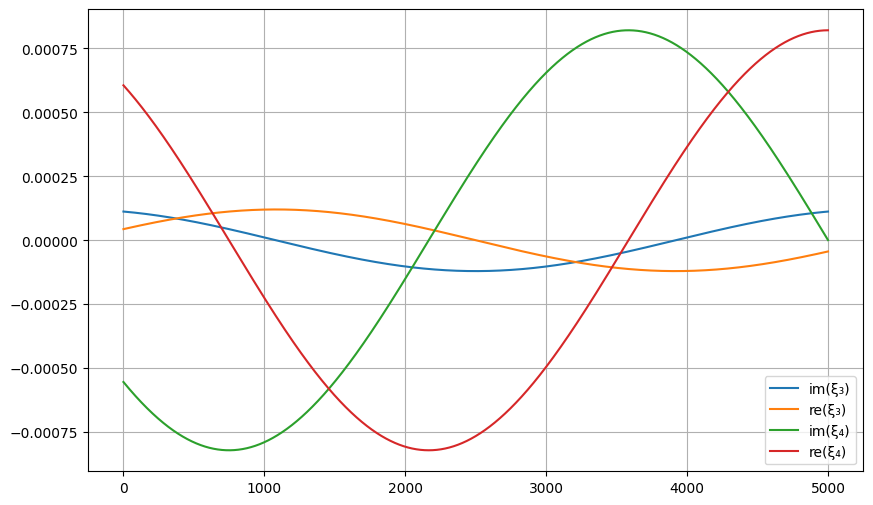

In [76]:
fig = plt.figure(figsize=(10,6))
#plt.plot(d.index, d['b₁'], label='b₁')
#plt.plot(d.index, d['b₂'], label='b₂')
#plt.plot(d.index, d['b₃'], label='b₃')
#plt.plot(d.index, d['ξ₂'], label='ξ₂')
plt.plot(d.index, d['im(ξ₃)'], label='im(ξ₃)')
plt.plot(d.index, d['re(ξ₃)'], label='re(ξ₃)')
plt.plot(d.index, d['im(ξ₄)'], label='im(ξ₄)')
plt.plot(d.index, d['re(ξ₄)'], label='re(ξ₄)')
plt.legend()
plt.grid()
plt.show()

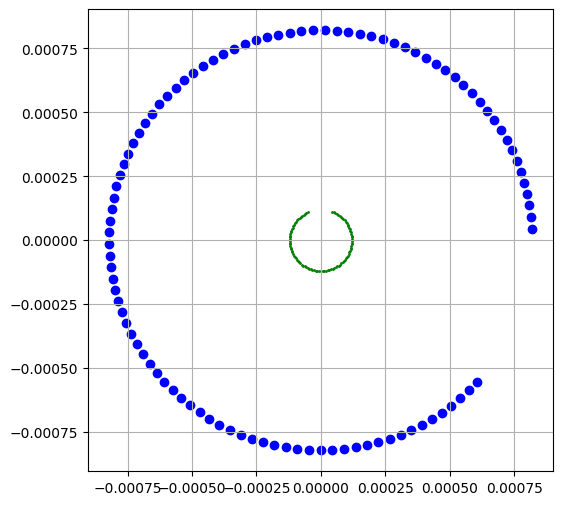

In [88]:
fig = plt.figure(figsize=(6,6))
for j, i in enumerate(d.index):
    if j % 50 == 0:
        plt.scatter(d['re(ξ₃)'][i], d['im(ξ₃)'][i], c='g', s=1)
        # plt.scatter(d['re(ξ₃)'][i], -d['im(ξ₃)'][i], c='b', s=1)
        plt.scatter(d['re(ξ₄)'][i], d['im(ξ₄)'][i], c='b')
        # plt.scatter(d['re(ξ₄)'][i], -d['im(ξ₄)'][i], c='y')
plt.grid()
plt.show()

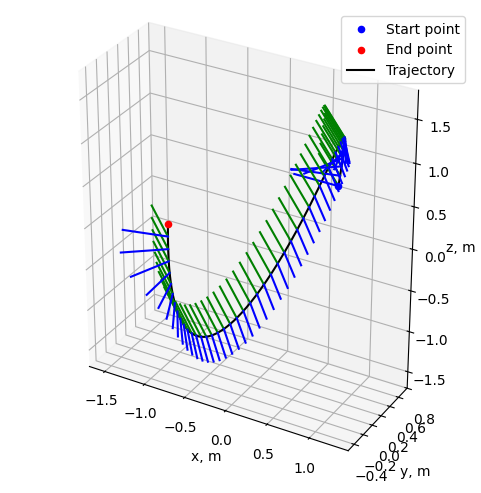

In [92]:
fig = plt.figure(figsize=(12,6))
for iii in range(2):
    v0[0] = v0[0] if iii==0 else v0x(w, *r0)
    axes = fig.add_subplot(1, 2, iii+1, projection='3d')
    rn = np.zeros((T // dt,3))
    for i in range(T // dt):
        rn[i,:] = A(w0, dt*i) @ r0 + B(w0, dt*i) @ v0
    axes.scatter(*r0, c='b', label='Start point')
    axes.scatter(*r1, c='r', label='End point')
    axes.plot(*[rn[:,i] for i in range(3)], c='k', label='Trajectory')
    for j in range(T // dt):
        r = A(w0, dt*j) @ r0 + B(w0, dt*j) @ v0
        v = C(w0, dt*j) @ r0 + D(w0, dt*j) @ v0
        if j % 100 == 0:
            # bn1 = bn(r0, v0, w0, dt*j).T[0]
            # bn1 /= np.linalg.norm(bn1)
            # axes.plot(*[[rn[j,i], rn[j,i] + 0.5*bn1[i]] for i in range(3)], c='r', label=None)
            
            bn2 = z3(r0, v0, w0) # .T[0]
            bn2 /= np.linalg.norm(bn2)
            axes.plot(*[[rn[j,i], rn[j,i] + 0.5*bn2[i]] for i in range(3)], c='g')
    
            bn3 = np.array([2*(r[1]*v[2]-r[2]*v[1])/w0, 
                            -4*r[1]*r[0]-4*v[1]*v[2]/w0**2, 
                            4*r[1]**2 + 4*v[1]**2/w0**2])
            bn3 /= np.linalg.norm(bn3)
            axes.plot(*[[rn[j,i], rn[j,i] + 0.5*bn3[i]] for i in range(3)], c='b')
    axes.legend()
    axes.set_xlabel("x, m")
    axes.set_ylabel("y, m")
    axes.set_zlabel("z, m")
    axes.set_aspect('equal')
plt.show()

###### Потуги 4: **Продолжение "Жордановой формы"**

In [115]:
r_1 = A(w,t) @ r0 + B(w,t) @ v0
v_1 = C(w,t) @ r0 + D(w,t) @ v0
g = Matrix([2*v1[1]/w, -0.5*v1[0]/w, r1[2]])

g0 = g.subs([(r1[i], r0[i]) for i in range(3)] + [(v1[i], v0[i]) for i in range(3)])
g1 = g.subs([(r1[i], r_1[i]) for i in range(3)] + [(v1[i], v_1[i]) for i in range(3)])
gn = kf.cross(g0, g1)

In [116]:
for i in gn:
    display(i)

0.5*r^0_z*(r^0_y*(6*w_0*cos(t*w_0) - 6*w_0) + v^0_x*(4*cos(t*w_0) - 3) - 2*v^0_y*sin(t*w_0))/w_0 - 0.5*v^0_x*(r^0_z*cos(t*w_0) + v^0_z*sin(t*w_0)/w_0)/w_0

2*r^0_z*(3*r^0_y*w_0*sin(t*w_0) + 2*v^0_x*sin(t*w_0) + v^0_y*cos(t*w_0))/w_0 - 2*v^0_y*(r^0_z*cos(t*w_0) + v^0_z*sin(t*w_0)/w_0)/w_0

1.0*v^0_x*(3*r^0_y*w_0*sin(t*w_0) + 2*v^0_x*sin(t*w_0) + v^0_y*cos(t*w_0))/w_0**2 - 1.0*v^0_y*(r^0_y*(6*w_0*cos(t*w_0) - 6*w_0) + v^0_x*(4*cos(t*w_0) - 3) - 2*v^0_y*sin(t*w_0))/w_0**2

In [118]:
g1.subs(t, 2*pi/w)

Matrix([
[   2*v^0_y/w_0],
[-0.5*v^0_x/w_0],
[         r^0_z]])

In [117]:
gn.subs(t, 2*pi/w)

Matrix([
[0],
[0],
[0]])

###### Потуги 4: **ХКУ (чистый)**

In [12]:
kf.my_print(f"Решение ХКУ:", bold=True)
for a in anw:
    display(a.simplify())

Решение ХКУ:


Eq(r_x(t), (2*v^0_y*cos(t*w_0) - 2*v^0_y + w_0*(r^0_x - 3*t*(2*r^0_y*w_0 + v^0_x)) + (6*r^0_y*w_0 + 4*v^0_x)*sin(t*w_0))/w_0)

Eq(r_y(t), (4*r^0_y*w_0 + 2*v^0_x + v^0_y*sin(t*w_0) - (3*r^0_y*w_0 + 2*v^0_x)*cos(t*w_0))/w_0)

Eq(r_z(t), r^0_z*cos(t*w_0) + v^0_z*sin(t*w_0)/w_0)

Eq(v_x(t), -6*r^0_y*w_0 - 3*v^0_x - 2*v^0_y*sin(t*w_0) + (6*r^0_y*w_0 + 4*v^0_x)*cos(t*w_0))

Eq(v_y(t), v^0_y*cos(t*w_0) + (3*r^0_y*w_0 + 2*v^0_x)*sin(t*w_0))

Eq(v_z(t), -r^0_z*w_0*sin(t*w_0) + v^0_z*cos(t*w_0))

In [50]:
r = kf.get_vars(name='r', n=3, numb=False)
v = kf.get_vars(name='v', n=3, numb=False)
t1 = Matrix([
    6*r[1] + 4*v[0]/w,
    v[1]/w,
    v[2]/w
])
t2 = Matrix([
    2*v[1]/w,
    -3*r[1] - 2*v[0]/w,
    r[2]
])
display(t1.T)
display(t2.T)

t3 = t1.cross(t2)
t3 /= sqrt(sum([t3[i]**2 for i in range(3)]))
t3.simplify()
n_hkw = lambdify([w, r[0], r[1], r[2], v[0], v[1], v[2]], t3)  #, 'numpy')
display(t3)

Matrix([[6*r_y + 4*v_x/w_0, v_y/w_0, v_z/w_0]])

Matrix([[2*v_y/w_0, -3*r_y - 2*v_x/w_0, r_z]])

Matrix([
[     (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))/sqrt(4*(v_y**2 + (3*r_y*w_0 + 2*v_x)**2)**2 + (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))**2 + 4*(r_z*w_0*(3*r_y*w_0 + 2*v_x) - v_y*v_z)**2)],
[(-2*r_z*w_0*(3*r_y*w_0 + 2*v_x) + 2*v_y*v_z)/sqrt(4*(v_y**2 + (3*r_y*w_0 + 2*v_x)**2)**2 + (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))**2 + 4*(r_z*w_0*(3*r_y*w_0 + 2*v_x) - v_y*v_z)**2)],
[      -(2*v_y**2 + 2*(3*r_y*w_0 + 2*v_x)**2)/sqrt(4*(v_y**2 + (3*r_y*w_0 + 2*v_x)**2)**2 + (r_z*v_y*w_0 + v_z*(3*r_y*w_0 + 2*v_x))**2 + 4*(r_z*w_0*(3*r_y*w_0 + 2*v_x) - v_y*v_z)**2)]])

##### <u>Условие нестолкновения</u>

###### *Расстояние между отрезками + расстояние между точками и торцами цилиндра*

In [123]:
def point2line(p, r1, r2):
    if norm(r2 - r1) == 0:
        return -1
    tau = (r2 - r1) / norm(r2 - r1)
    kk = np.dot(tau, p - r1)  # Положение проекции точки P на линии отрезка
    if 0<=kk<=norm(r2 - r1):  # Если проекция внутри отрезка
        return norm(p - (r1 + kk*tau))
    return -1

def point2circle(p, r1, r2):
    if norm(r2 - r1) == 0:
        return -1
    n = (r2 - r1) / norm(r2 - r1)
    d1 = norm(p - r2)
    if d1 == 0:
        return 0
    cosa = np.dot(n, p - r2) / d1
    sina = np.sqrt(1 - cosa**2)
    kk = d1 * sina
    if cosa >= 0:
        if 0<=kk<=d:
            return d1*cosa
        if kk>d:
            return np.sqrt(((d1)*cosa)**2 + ((d1-d)*sina)**2) 
    return -1

def line2circle(r1, r2, ro1, ro2):
    if norm(r2 - r1) == 0:
        return -1
    n = (ro2 - ro1) / norm(ro2 - ro1)
    tau = (r2 - r1) / norm(r2 - r1)
    kk = np.dot(tau, ro2 - r1)  # Положение проекции точки ro2 на линии отрезка r1-r2
    # Проверка на пересечение
    tmp = np.dot(n, tau)
    if tmp == 0:
        return -1 # np.clip(point2line(ro2, r1, r2) - d, 0, None)
    else:
        k = np.dot(n, ro2-r1) / tmp
        if norm(k*tau + r1 - ro2) < d and 0<k<norm(r2 - r1):
            return 0
    
    b = np.cross(n, tau)
    if norm(b) == 0:
        return -1
    b /= norm(b)
    j = d * np.cross(b, n)
    tmp = [i for i in [point2line(ro2 + j, r1, r2), point2line(ro2 - j, r1, r2)] if i > -1]
    return min(tmp) if len(tmp)>0 else -1

def h(r1, r2, ro1, ro2):
    # Расстояния между отрезками
    d1 = [point2line(ro1, r1, r2),
          point2line(ro2, r1, r2), 
          point2line(r1, ro1, ro2) - d, 
          point2line(r2, ro1, ro2) - d]
    # Расстояния от точек траектории до торцов цилиндра
    d2 = [point2circle(r1, ro2, ro1),
          point2circle(r2, ro2, ro1),
          point2circle(r1, ro1, ro2),
          point2circle(r2, ro1, ro2)]
    # Расстояния от отрезка траектории до торца цилиндра
    d3 = [line2circle(r1, r2, ro1, ro2),
          line2circle(r1, r2, ro2, ro1)]
    return min([x for x in d1 + d2 + d3 if x > -1])

k = lambda x_: (x_ / (2*dx) + 0.5) * N_heatmap
k1 = lambda x_: (x_ / (2*dx)) * N_heatmap
k_ = lambda i_: (i_ / N_heatmap - 0.5) * (2*dx)

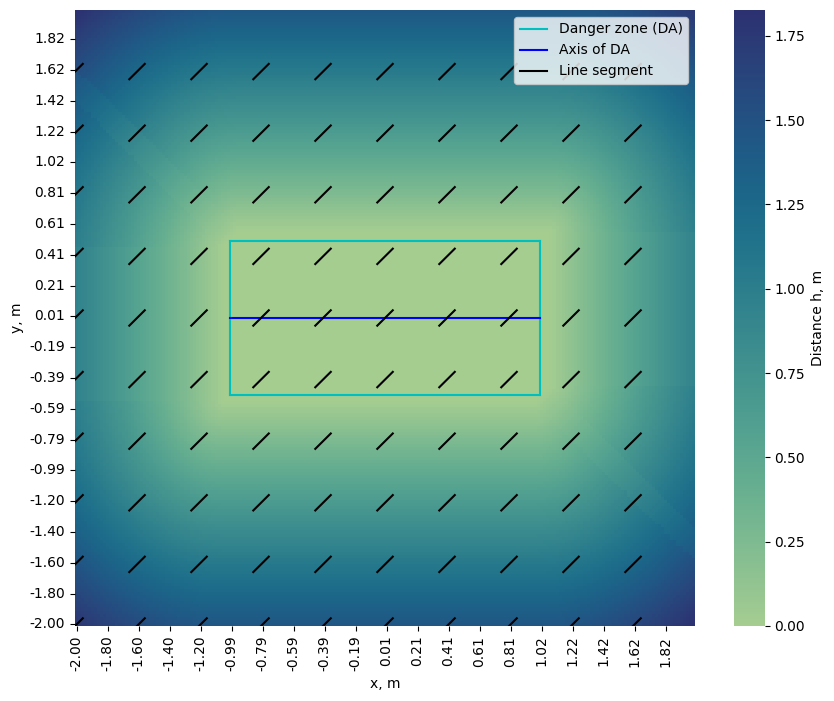

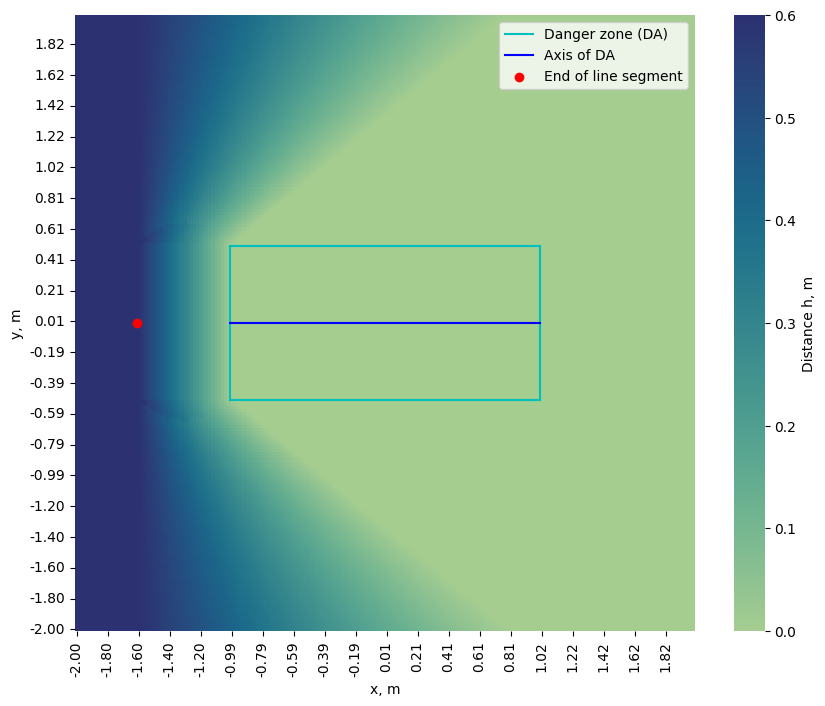

In [124]:
#>>>>>>>>>> Конец функций <<<<<<<<<<#
N_heatmap = 200
rate = 10
dx = 2
x_list = np.linspace(-dx, dx, N_heatmap)
y_list = np.linspace(-dx, dx, N_heatmap)

d = 0.5
dr = np.array([0.05, 0.05, 0])
ro1, ro2 = np.array([-1, 0, 0]), np.array([1, 0, 0])

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for j in range(2):
    if j == 0:
        anw = np.array([[h(r1=np.array([k_(ix), k_(iy), 0]) - dr, 
                           r2=np.array([k_(ix), k_(iy), 0]) + dr,
                           ro1=ro1, ro2=ro2) for ix in range(N_heatmap)] for iy in range(N_heatmap)])
    else:
        r1 = ro1 - np.array([0.6, 0., 0])
        anw = np.array([[h(ro1=ro1, ro2=ro2, r1=r1, r2=np.array([k_(ix), k_(iy), 0])) 
                       for ix in range(N_heatmap)] for iy in range(N_heatmap)])
    anw = np.clip(anw, 0, None)

    fig, axes = plt.subplots(1, 1, figsize=(10, 8))
    v_x_list, v_z_list = [np.linspace(-dx, dx, N_heatmap) for _ in range(2)]
    xlabels_0, ylabels_0 = [['{:4.2f}'.format(x) for x in l] for l in [v_z_list, v_x_list]]
    ax = sns.heatmap(anw, ax=axes, cmap="crest", xticklabels=xlabels_0, yticklabels=ylabels_0, cbar_kws={'label': 'Distance h, m'})
    ax.set_xticks(ax.get_xticks()[::rate]); ax.set_xticklabels(xlabels_0[::rate])
    ax.set_yticks(ax.get_yticks()[::rate]); ax.set_yticklabels(ylabels_0[::rate])
    ax.plot([k(ro1[0]), k(ro2[0])], [k(ro1[1]+d), k(ro2[1]+d)], c='c', label='Danger zone (DA)')
    ax.plot([k(ro1[0]), k(ro2[0])], [k(ro1[1]-d), k(ro2[1]-d)], c='c')
    ax.plot([k(ro1[0]), k(ro1[0])], [k(ro1[1]-d), k(ro1[1]+d)], c='c')
    ax.plot([k(ro2[0]), k(ro2[0])], [k(ro2[1]-d), k(ro2[1]+d)], c='c')
    ax.plot([k(ro1[0]), k(ro2[0])], [k(ro1[1]), k(ro2[1])], c='b', label='Axis of DA')
    flag = True
    if j == 0:
        for ix in range(N_heatmap):
            for iy in range(N_heatmap):
                if ((ix) % 20 == 0) and ((iy) % 20 == 0):
                    ax.plot([ix-k1(dr[0]), ix+k1(dr[0])], [iy-k1(dr[1]), iy+k1(dr[1])], c='k', label = "Line segment" if flag else None)
                    flag = False
    else:
         ax.scatter(k(r1[0]), k(r1[1]), c='r', label='End of line segment')
        #for ix in range(N_heatmap):
        #    for iy in range(N_heatmap):
        #        if ((ix+0) % 30 == 0) and ((iy+0) % 30 == 0):
        #            ax.plot([k(r1[0]), ix], [k(r1[1]), iy], c='k', lw=0.5)
    ax.set_xlabel(f"x, m")
    ax.set_ylabel(f"y, m")
    ax.invert_yaxis()
    ax.legend()
    plt.show()

##### <u>Область достижимости</u>

In [19]:
# Начальные условия для достижения точки
v0_ = B(w, t).inv() @ (r1 - A(w, t) @ r0)
for i in range(3):
    kf.my_print(f"Требуемый импульс по O" + "xyz"[i], bold=True)
    v0_[i] = v0_[i].simplify()
    display(v0_[i])
v0n = lambdify([*r0, *r1, t, w], v0_)

Требуемый импульс по Ox


w_0*(-2*(r^0_y*(3*cos(t*w_0) - 4) + r^1_y)*(cos(t*w_0) - 1) + (-r^0_x + 6*r^0_y*(t*w_0 - sin(t*w_0)) + r^1_x)*sin(t*w_0))/(-3*t*w_0*sin(t*w_0) - 8*cos(t*w_0) + 8)

Требуемый импульс по Oy


w_0*(-(r^0_y*(3*cos(t*w_0) - 4) + r^1_y)*(3*t*w_0 - 4*sin(t*w_0)) + 2*(cos(t*w_0) - 1)*(-r^0_x + 6*r^0_y*(t*w_0 - sin(t*w_0)) + r^1_x))/(-3*t*w_0*sin(t*w_0) - 8*cos(t*w_0) + 8)

Требуемый импульс по Oz


w_0*(-r^0_z*cos(t*w_0) + r^1_z)/sin(t*w_0)

###### *Различие траекторий в зависимости от конечной точки*

In [ ]:
# Проверим "различие" траекторий для достижений соседних точек
r0n = np.array([3, 1, 1])  # np.zeros(3)
dt, T = 1, 5000
w0 = o.v.W_ORB
ds = [-1, -0.5, 0.5, 1]

axes = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
axes.scatter(*r0n, c='blue', label='Start point')
v_list = []
flag = True
for x in ds:
    for y in ds:
        for z in ds:
            v = v0req(w0, T, r0n, np.array([x, y, z]))  #.T[0]
            v_list.append(v)
            rn = np.zeros([int(T // dt), 3])
            for i in range(int(T // dt)):
                rn[i] = A(w0, i*dt) @ r0n + B(w0, i*dt) @ v
            axes.plot(*[rn[:,j] for j in range(3)], c='tan', alpha=0.9)
            axes.scatter(x, y, z, c='peru', label='End points' if flag else None)
            flag = False
axes.scatter(*r0n, c='blue')  # Повторение для видимости точки
axes.set_xlabel("x, m")
axes.set_ylabel("y, m")
axes.set_zlabel("z, m")
plt.legend()
plt.show()

for v in v_list:
    plt.scatter(v[0], v[1], c='peru')
plt.title("Initial velocities")
plt.xlabel("vˣ, m/s")
plt.xlabel("vʸ, m/s")
plt.grid()
plt.show()

ds: [-5.  -2.5  0.   2.5  5. ]


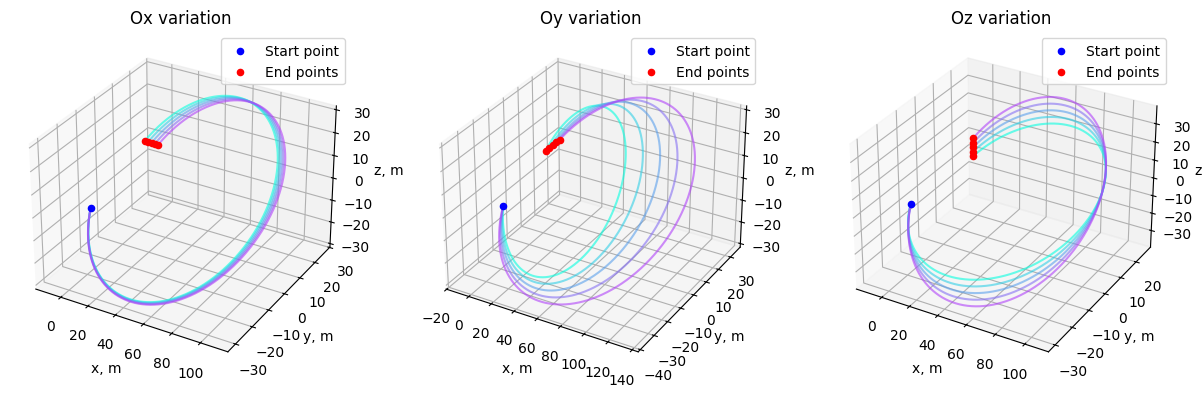

In [235]:
# Проверим "различие" траекторий для достижений точки с разным временем
r0n = np.array([-10, -10, -10])  # np.zeros(3)
r1n = np.array([10, 10, 10])  # np.zeros(3)
dt, T = 1, 5000
w0 = o.v.W_ORB
ds = np.linspace(-5, 5, 5)
print(f"ds: {ds}")

fig = plt.figure(figsize=(15,10))

for ii in range(3):
    axes = fig.add_subplot(2, 3, ii+1, projection='3d')
    axes.scatter(*r0n, c='blue', label='Start point')
    for i, s in enumerate(ds):
        dr1n = np.array([s*int(ii==k) for k in range(3)])
        v = v0req(w0, T, r0n, r1n + dr1n)
        rn = np.zeros([int(T // dt), 3])
        for j in range(int(T // dt)):
            rn[j] = A(w0, j*dt) @ r0n + B(w0, j*dt) @ v
        axes.plot(*[rn[:,j] for j in range(3)], color=mycolor(i / len(ds)), alpha=0.6)
        axes.scatter(*(r1n+dr1n), c='red', label='End points' if i==0 else None)
    axes.set_xlabel("x, m")
    axes.set_ylabel("y, m")
    axes.set_zlabel("z, m")
    # axes.set_aspect('equal')
    axes.set_title(["Ox variation", "Oy variation", "Oz variation"][ii])
    axes.legend()
plt.show()

In [213]:
# Символьно проверим различия между начальными условиями и конечной точкой. Для этого, продифференцируем:
J1 = v0req(w, t, r0, r1).jacobian(r1)
kf.my_print(f"Якобиан требуемой начальной скорости по конечному положению:", bold=True)
display(J1)
kf.my_print(f"Подставим характерные значения времени:", bold=True)
display(J1.subs([(w, w0), (t, T)]))

Якобиан требуемой начальной скорости по конечному положению:


Matrix([
[            -w_0*sin(t*w_0)/(3*t*w_0*sin(t*w_0) - 4*sin(t*w_0)**2 - 4*cos(t*w_0)**2 + 8*cos(t*w_0) - 4),      (2*w_0*cos(t*w_0) - 2*w_0)/(3*t*w_0*sin(t*w_0) - 4*sin(t*w_0)**2 - 4*cos(t*w_0)**2 + 8*cos(t*w_0) - 4),              0],
[(-2*w_0*cos(t*w_0) + 2*w_0)/(3*t*w_0*sin(t*w_0) - 4*sin(t*w_0)**2 - 4*cos(t*w_0)**2 + 8*cos(t*w_0) - 4), (3*t*w_0**2 - 4*w_0*sin(t*w_0))/(3*t*w_0*sin(t*w_0) - 4*sin(t*w_0)**2 - 4*cos(t*w_0)**2 + 8*cos(t*w_0) - 4),              0],
[                                                                                                      0,                                                                                                           0, w_0/sin(t*w_0)]])

Подставим характерные значения времени:


Matrix([
[-5.61714642664918e-5,  4.36262382580135e-5,                    0],
[-4.36262382580135e-5, -0.00160857362807932,                    0],
[                   0,                    0, -0.00164245646680176]])

In [214]:
J1_ = J1.subs(t, 2*pi*(1 - tau)/w)
J1_.simplify()
display(J1_)
for i in range(9):
    J1_[i] = series(J1_[i], tau, 0, 2)
display(J1_)

Matrix([
[w_0*cos(pi*tau)/(2*(3*pi*tau*cos(pi*tau) - 4*sin(pi*tau) - 3*pi*cos(pi*tau))),                                  w_0*sin(pi*tau)/(-3*pi*tau*cos(pi*tau) + 4*sin(pi*tau) + 3*pi*cos(pi*tau)),                  0],
[    w_0*sin(pi*tau)/(3*pi*tau*cos(pi*tau) - 4*sin(pi*tau) - 3*pi*cos(pi*tau)), w_0*(3*pi*(tau - 1) - 2*sin(2*pi*tau))/(-3*pi*tau*sin(2*pi*tau) + 3*pi*sin(2*pi*tau) - 4*cos(2*pi*tau) + 4),                  0],
[                                                                            0,                                                                                                           0, -w_0/sin(2*pi*tau)]])

Matrix([
[-w_0/(6*pi) + tau*w_0/(18*pi) + O(tau**2),                                                           tau*w_0/3 + O(tau**2),                                          0],
[                   -tau*w_0/3 + O(tau**2), -w_0/(2*pi*tau) + tau*(-w_0*(1/9 + 2*pi**2/3)/(2*pi) + w_0/(18*pi)) + O(tau**2),                                          0],
[                                        0,                                                                               0, -w_0/(2*pi*tau) - pi*tau*w_0/3 + O(tau**2)]])

In [233]:
# Символьно проверим различия между траекторией и конечной точкой. Посмотрим на середину траектории
rn = A(w, t/2) @ r0 + B(w, t/2) @ v0req(w, t, r0, r1)
J2 = rn.jacobian(r1).subs(t, 2*pi*(1 - tau)/w)
for i in range(9):
    J2[i] = series(J2[i], tau, 0, 2)
J2.simplify()
kf.my_print(f"Якобиан средней точки по конечному положению:", bold=True)
display(J2)
kf.my_print(f"Подставим характерные значения времени:", bold=True)
for i in range(9):
    J2[i] = J2[i].removeO()
tmp = J2.subs([(w, w0), (t, T), (tau, 0.1), (pi, np.pi)])
display(tmp)

Якобиан средней точки по конечному положению:


Matrix([
[                1/2 + O(tau**2), 2/(pi*tau) - pi*tau/6 + O(tau**2),                0],
[(-6 + 2*tau + O(tau**2))/(9*pi),        -1/2 + 4*tau/3 + O(tau**2),                0],
[                              0,                                 0, -1/2 + O(tau**2)]])

Подставим характерные значения времени:


Matrix([
[ 1/2,   6.31383784611598,    0],
[O(1), -0.366666666666667,    0],
[   0,                  0, -1/2]])

**Вывод:** Траектория сильно наклоняется при малом изменении конечного положения

###### *Различие траекторий в зависимости от времени перелёта*

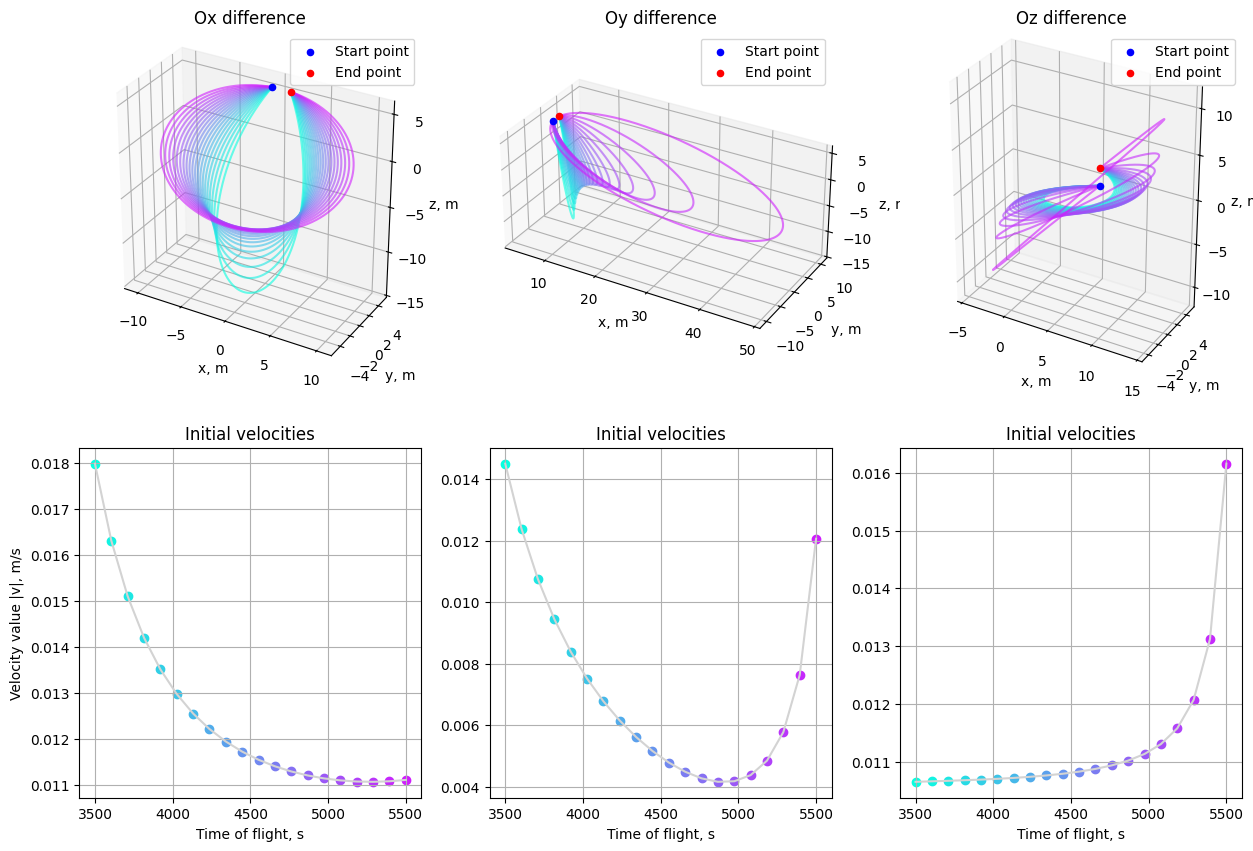

In [146]:
# Проверим "различие" траекторий для достижений точки с разным временем
dt, T_list = 1, np.linspace(3500, 5500, 20)
w0 = o.v.W_ORB
ds = [-1, -0.5, 0.5, 1]

fig = plt.figure(figsize=(15,10))

for ii in range(3):
    e = 5
    r0n = [[-1, e, e], [e, -1, e], [e, e, -1]][ii]
    r1n = [[1, e, e], [e, 1, e], [e, e, 1]][ii]
    
    axes = fig.add_subplot(2, 3, ii+1, projection='3d')
    axes.scatter(*r0n, c='blue', label='Start point')
    axes.scatter(*r1n, c='red', label='End point')
    v_list = []
    for i, T in enumerate(T_list):
        v = v0req(w0, T, r0n, r1n)
        v_list.append(v)
        rn = np.zeros([int(T // dt), 3])
        for j in range(int(T // dt)):
            rn[j] = A(w0, j*dt) @ r0n + B(w0, j*dt) @ v
        axes.plot(*[rn[:,j] for j in range(3)], color=mycolor(i / len(T_list)), alpha=0.6)
    # axes.scatter(*r0n, c='blue')  # Повторение для видимости точки
    # axes.scatter(*r1n, c='red')  # Повторение для видимости точки
    axes.set_xlabel("x, m")
    axes.set_ylabel("y, m")
    axes.set_zlabel("z, m")
    axes.set_aspect('equal')
    axes.set_title(["Ox difference", "Oy difference", "Oz difference"][ii])
    axes.legend()
    
    ax = fig.add_subplot(2, 3, ii+4)
    ax.plot(T_list, [norm(v) for v in v_list], c='lightgray')
    for i in range(len(T_list)):
        ax.scatter(T_list[i], norm(v_list[i]), color=mycolor(i / len(T_list)))
    ax.set_title("Initial velocities")
    ax.set_xlabel("Time of flight, s")
    ax.set_ylabel("Velocity value |v|, m/s" if ii==0 else None)
    ax.grid()
plt.show()

In [243]:
# Посмотрим на середину траектории
rn = A(w, t/2) @ r0 + B(w, t/2) @ v0req(w, t, r0, r1)
rn_t = rn.subs(t, 2*pi*(1 - tau)/w).diff(tau)
for i in range(3):
    rn_t[i] = series(rn_t[i], tau, 0, 2)
rn_t.simplify()
kf.my_print(f"Дифференциал средней точки по параметру τ:", bold=True)
display(rn_t)
kf.my_print(f"Подставим характерные значения времени:", bold=True)
for i in range(3):
    rn_t[i] = rn_t[i].expand()
    rn_t[i] = rn_t[i].removeO()
tmp = rn_t.subs([(w, w0), (t, T), (tau, 0.1), (pi, np.pi)] + 
                [(r1[i], 10) for i in range(3)] +
                [(r0[i], -10) for i in range(3)])
display(tmp)

Дифференциал средней точки по параметру τ:


Matrix([
[                                                                                                                                         -2*r^1_y/(pi*tau**2) - pi*r^1_y/6 + 2*r^0_y/(pi*tau**2) + pi*r^0_y/6 + O(tau**2)],
[(72*pi*r^1_y - 48*pi*r^1_y*tau - 27*pi**3*r^1_y*tau + 12*r^1_x - 8*r^1_x*tau - 18*pi**2*r^1_x*tau + 72*pi*r^0_y - 48*pi*r^0_y*tau - 27*pi**3*r^0_y*tau - 12*r^0_x + 18*pi**2*r^0_x*tau + 8*r^0_x*tau + O(tau**2))/(54*pi)],
[                                                                                                                                                                                 -pi**2*tau*(r^0_z + r^1_z)/2 + O(tau**2)]])

Подставим характерные значения времени:


Matrix([
[                                                                                                                                                      pi*r^0_y/6 + 2*r^0_y/(pi*tau**2) - pi*r^1_y/6 - 2*r^1_y/(pi*tau**2)],
[(72*pi*r^1_y - 48*pi*r^1_y*tau - 27*pi**3*r^1_y*tau + 12*r^1_x - 8*r^1_x*tau - 18*pi**2*r^1_x*tau + 72*pi*r^0_y - 48*pi*r^0_y*tau - 27*pi**3*r^0_y*tau - 12*r^0_x + 18*pi**2*r^0_x*tau + 8*r^0_x*tau + O(tau**2))/(54*pi)],
[                                                                                                                                                                                             -pi**2*tau*(r^0_z + r^1_z)/2]])

Matrix([
[ -1283.71152024713],
[-0.773998537482656],
[                 0]])

$$\delta n = \frac{\partial n}{\partial \tau}\delta \tau$$

In [ ]:
n = n_hkw(w, *r0, *v0req(w, t, r0, r1))
n = n.subs(t, 2*pi*(1 - tau)/w)
n.simplify()
for i in range(3):
   n[i] = series(n[i], tau, 0, 2)
#n /= kf.norm(n)
n.simplify()
display(n)

In [ ]:
n = n.expand()
display(n)

In [ ]:
n_t = n.diff(tau)
display(n_t)

$$\delta b = \frac{\partial b}{\partial \tau}\delta \tau$$

In [ ]:
b = b_mean(r0, v0req(w, t, r0, r1), w)
b = b.subs(t, 2*pi*(1 - tau)/w)
b.simplify()
for i in range(3):
   b[i] = series(b[i], tau, 0, 1)
b /= kf.norm(b)
b.simplify()

In [133]:
b

Matrix([
[                                                                                                                                                                                       (-9*pi**4*w_0**3*(r^0_x*r^0_z - r^0_x*r^1_z - r^0_z*r^1_x + r^1_x*r^1_z + 3*pi*(r^0_y*r^1_z - r^0_z*r^1_y)) - 18*pi**5*tau*w_0**3*(r^0_y*r^0_z - r^0_y*r^1_z + r^0_z*r^1_y - r^1_y*r^1_z) - 3*pi**4*tau*w_0**3*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z) + O(tau**2))/(tau*sqrt((9*tau**2*(3*pi**4*w_0**3*(r^0_x*r^0_z - r^0_x*r^1_z - r^0_z*r^1_x + r^1_x*r^1_z + 3*pi*(r^0_y*r^1_z - r^0_z*r^1_y)) + 6*pi**5*tau*w_0**3*(r^0_y*r^0_z - r^0_y*r^1_z + r^0_z*r^1_y - r^1_y*r^1_z) + pi**4*tau*w_0**3*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z) + O(tau**2))**2 + 9*pi**8*(6*pi*tau**2*w_0**3*(-r^0_x*r^0_z - r^0_x*r^1_z + r^0_z*r^1_x + r^1_x*r^1_z) + tau**2*w_0**3*(-r^0_y*r^0_z + r^0_y*r^0_z*(1 + 6*pi**2) - r^0_y*r^1_z*(1 + 6*pi**2) + r^0_y*r^1_z - r^0_z*r^1_y*(1 + 6*pi**2) + r^0_z*r^1_y - r^1

In [134]:
b_t = b.diff(tau)

In [135]:
b_t

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           tau**3*(-(9*tau**2*(12*pi**5*w_0**3*(r^0_y*r^0_z - r^0_y*r^1_z + r^0_z*r^1_y - r^1_y*r^1_z) + 2*pi**4*w_0**3*(-r^0_x*r^0_z + r^0_x*r^1_z + r^0_z*r^1_x - r^1_x*r^1_z) + O(tau))*(3*pi**4*w_0**3*(r^0_x*r^0_z - r^0_x*r^1_z - r^0_z*r^1_x + r^1_x*r^1_z + 3*pi*(r^0_y*r^1_z - r^0_z*r^1_y)) + 6*pi**5*tau*w_0**3*(r^0_y*r^0_z - r^0_y*r^1_z + r^0_z*r^1_y - r^1_y*r^1_z) + pi**4*tau*w_0**3*(-r^0_x*

##### <u>Ошибки импульса</u>

**Ошибки по скорости**

In [2]:
dt = 1
T = 5000
w0 = o.v.W_ORB
r0 = np.array([2, 3, 4])
r1 = np.array([-3, -10, -3])
v0 = v0req(w0, T, r0, r1)
print(f"Скорость: {v0}")

rs = np.zeros((T // dt,3))
for i in range(T // dt):
    rs[i,:] = A(w0, dt*i) @ r0 + B(w0, dt*i) @ v0

Скорость: [-0.00667537  0.02004152  0.00977538]


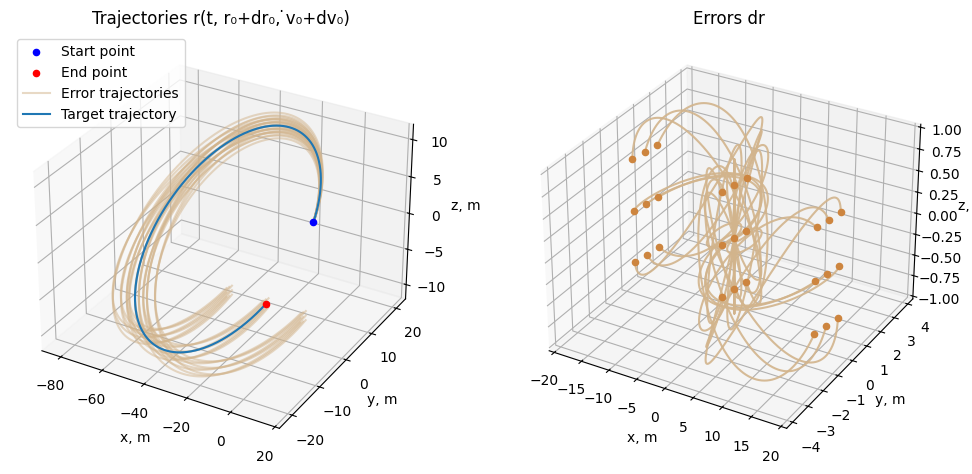

In [147]:
ds = [-0.001, 0, 0.001]
dvs = [[dvx, dvy, dvz] for dvx in ds for dvy in ds for dvz in ds]
rs_list = []

fig = plt.figure(figsize=(12,6))

axes = fig.add_subplot(1, 2, 1, projection='3d')
axes.scatter(rs[0,0], rs[0,1], rs[0,2], c='b', label='Start point')
axes.scatter(rs[-1,0], rs[-1,1], rs[-1,2], c='r', label='End point')
for j, dv in enumerate(dvs):
    rs_ = np.zeros((T//dt,3))
    for i in range(T // dt):
        rs_[i,:] = A(w0, dt*i) @ r0 + B(w0, dt*i) @ (v0 + np.array(dv))
    axes.plot(rs_[:,0], rs_[:,1], rs_[:,2], c='tan', alpha=0.5, label='Error trajectories' if j==0 else None)
    rs_list += [rs - rs_]
axes.plot(rs[:,0], rs[:,1], rs[:,2], label='Target trajectory')
axes.legend()
axes.set_xlabel("x, m")
axes.set_ylabel("y, m")
axes.set_zlabel("z, m")
axes.set_title("Trajectories r(t, r₀+dr₀, ̇v₀+dv₀)")

axes = fig.add_subplot(1, 2, 2, projection='3d')
for rs_ in rs_list:
    axes.plot(*[rs_[:,i] for i in range(3)], c='tan', alpha=0.9)
    axes.scatter(*[rs_[-1,i] for i in range(3)], c='peru')
axes.set_xlabel("x, m")
axes.set_ylabel("y, m")
axes.set_zlabel("z, m")
axes.set_title("Errors dr")
# axes.set_aspect('equal')
plt.show()

**А теперь ошибки по положению**

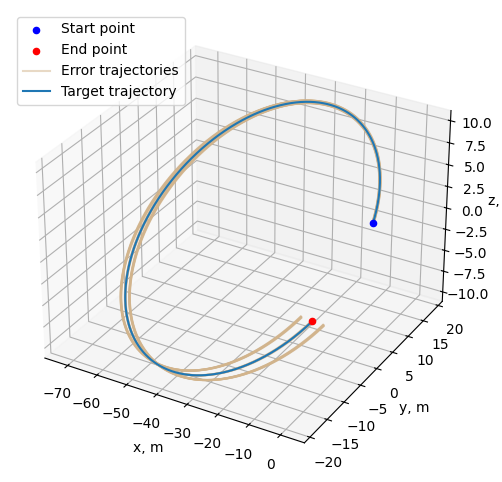

In [142]:
ds = [-0.1, 0, 0.1]
drs = [[dvx, dvy, dvz] for dvx in ds for dvy in ds for dvz in ds]
rs_list = []

axes = plt.figure(figsize=(12, 6)).add_subplot(projection='3d')
axes.scatter(rs[0,0], rs[0,1], rs[0,2], c='b', label='Start point')
axes.scatter(rs[-1,0], rs[-1,1], rs[-1,2], c='r', label='End point')
for j, dr in enumerate(drs):
    rs_ = np.zeros((T//dt,3))
    for i in range(T//dt):
        rs_[i,:] = A(w0, dt*i) @ (r0 + np.array(dr)) + B(w0, dt*i) @ v0
    axes.plot(rs_[:,0], rs_[:,1], rs_[:,2], c='tan', alpha=0.5, label='Error trajectories' if j==0 else None)
    rs_list += [rs - rs_]
axes.plot(rs[:,0], rs[:,1], rs[:,2], label='Target trajectory')
axes.legend()
axes.set_xlabel("x, m")
axes.set_ylabel("y, m")
axes.set_zlabel("z, m")
plt.show()

**Формульное обоснование** (неправильно)

In [55]:
t, w0, h, tau = var('t w_0 h tau')
r = kf.get_vars(name='r^0', n=3, numb=False)
v = kf.get_vars(name='v^0', n=3, numb=False)
dv = kf.get_vars(name='dv^0', n=3, numb=False)
dr = kf.get_vars(name='dr^0', n=3, numb=False)
rs = A(w0, t) @ (r + dr) + B(w0, t) @ (v + dv)

kf.my_print(f"Положение от времени:", bold=True)
display(rs)
kf.my_print(f"Дифференциал r1 по компонентам начального положения:", bold=True)
r1Dr0 = rs.diff(r[0])*dr[0] + rs.diff(r[1])*dr[1] + rs.diff(r[2])*dr[2]
display(r1Dr0)
kf.my_print(f"Дифференциал r1 по компонентам начальной скорости:", bold=True)
r1Dv0 = rs.diff(v[0])*dv[0] + rs.diff(v[1])*dv[1] + rs.diff(v[2])*dv[2]
display(r1Dv0)

Положение от времени:


Matrix([
[dr^0_x + r^0_x + (dr^0_y + r^0_y)*(-6*t*w_0 + 6*sin(t*w_0)) + (dv^0_x + v^0_x)*(-3*t*w_0 + 4*sin(t*w_0))/w_0 + (dv^0_y + v^0_y)*(2*cos(t*w_0) - 2)/w_0],
[                                       (4 - 3*cos(t*w_0))*(dr^0_y + r^0_y) + (2 - 2*cos(t*w_0))*(dv^0_x + v^0_x)/w_0 + (dv^0_y + v^0_y)*sin(t*w_0)/w_0],
[                                                                                         (dr^0_z + r^0_z)*cos(t*w_0) + (dv^0_z + v^0_z)*sin(t*w_0)/w_0]])

Дифференциал r1 по компонентам начального положения:


Matrix([
[dr^0_x + dr^0_y*(-6*t*w_0 + 6*sin(t*w_0))],
[                dr^0_y*(4 - 3*cos(t*w_0))],
[                        dr^0_z*cos(t*w_0)]])

Дифференциал r1 по компонентам начальной скорости:


Matrix([
[dv^0_x*(-3*t*w_0 + 4*sin(t*w_0))/w_0 + dv^0_y*(2*cos(t*w_0) - 2)/w_0],
[               dv^0_x*(2 - 2*cos(t*w_0))/w_0 + dv^0_y*sin(t*w_0)/w_0],
[                                               dv^0_z*sin(t*w_0)/w_0]])

$$t=\frac{2\pi}{\omega_0} (1-\tau)$$

In [57]:
kf.my_print(f"Дифференциал r1 по компонентам начального положения:", bold=True)
dr1_dr0 = r1Dr0.subs(t, 2*pi*(1 - tau)/w0)
display(dr1_dr0)
for i in range(3):
    dr1_dr0[i] = series(dr1_dr0[i], tau, 0, 2)
dr1_dr0.simplify()
display(dr1_dr0)

kf.my_print(f"Дифференциал r1 по компонентам начальной скорости:", bold=True)
dr1_dv0 = r1Dv0.subs(t, 2*pi*(1 - tau)/w0)
dr1_dv0.simplify()
display(dr1_dv0)
for i in range(3):
    dr1_dv0[i] = series(dr1_dv0[i], tau, 0, 2)
dr1_dv0.simplify()
display(dr1_dv0)

Дифференциал r1 по компонентам начального положения:


Matrix([
[dr^0_x + dr^0_y*(-12*pi*(1 - tau) + 6*sin(pi*(2 - 2*tau)))],
[                        dr^0_y*(4 - 3*cos(pi*(2 - 2*tau)))],
[                                dr^0_z*cos(pi*(2 - 2*tau))]])

Matrix([
[-12*pi*dr^0_y + dr^0_x + O(tau**2)],
[                dr^0_y + O(tau**2)],
[                dr^0_z + O(tau**2)]])

Дифференциал r1 по компонентам начальной скорости:


Matrix([
[2*(dv^0_x*(3*pi*(tau - 1) - 2*sin(2*pi*tau)) + dv^0_y*(cos(2*pi*tau) - 1))/w_0],
[               (-2*dv^0_x*cos(2*pi*tau) + 2*dv^0_x - dv^0_y*sin(2*pi*tau))/w_0],
[                                                     -dv^0_z*sin(2*pi*tau)/w_0]])

Matrix([
[(-6*pi*dv^0_x - 2*pi*dv^0_x*tau + O(tau**2))/w_0],
[              (-2*pi*dv^0_y*tau + O(tau**2))/w_0],
[              (-2*pi*dv^0_z*tau + O(tau**2))/w_0]])

**Формульное обоснование** (правильно - через уравнение в вариациях) 

$$\delta r_1 = \frac{\partial r_1}{\partial X} \Phi(t,t_0) \delta X(t_0)$$

In [167]:
t, w0, h, tau = var('t w_0 h tau')
r = kf.get_vars(name='r^0', n=3, numb=False)
v = kf.get_vars(name='v^0', n=3, numb=False)
dv = kf.get_vars(name='dv^0', n=3, numb=False)
dr = kf.get_vars(name='dr^0', n=3, numb=False)
X = Matrix([r, v])
dX = Matrix([dr, dv])
Ф = kf.bmat([[A(w0, t), B(w0, t)],
             [C(w0, t), D(w0, t)]])

r1 = A(w0, t) @ r + B(w0, t) @ v
v1 = C(w0, t) @ r + D(w0, t) @ v
f = Matrix([r1, v1])
J = r1.jacobian(X)
dr1 = J @ Ф @ dX

kf.my_print(f"Якобиан r₁ от НУ:", bold=True)
display(J)
kf.my_print(f"δr₁ = JФdX:", bold=True)
display(dr1)

Якобиан r₁ от НУ:


Matrix([
[1, -6*t*w_0 + 6*sin(t*w_0),          0, (-3*t*w_0 + 4*sin(t*w_0))/w_0, (2*cos(t*w_0) - 2)/w_0,              0],
[0,        4 - 3*cos(t*w_0),          0,        (2 - 2*cos(t*w_0))/w_0,         sin(t*w_0)/w_0,              0],
[0,                       0, cos(t*w_0),                             0,                      0, sin(t*w_0)/w_0]])

δr₁ = JФdX:


Matrix([
[dr^0_x + dr^0_y*(-6*t*w_0 + (4 - 3*cos(t*w_0))*(-6*t*w_0 + 6*sin(t*w_0)) + 3*(2*cos(t*w_0) - 2)*sin(t*w_0) + 6*sin(t*w_0) + (-3*t*w_0 + 4*sin(t*w_0))*(6*w_0*cos(t*w_0) - 6*w_0)/w_0) + dv^0_x*((2 - 2*cos(t*w_0))*(-6*t*w_0 + 6*sin(t*w_0))/w_0 + (-3*t*w_0 + 4*sin(t*w_0))*(4*cos(t*w_0) - 3)/w_0 + (-3*t*w_0 + 4*sin(t*w_0))/w_0 + 2*(2*cos(t*w_0) - 2)*sin(t*w_0)/w_0) + dv^0_y*((-6*t*w_0 + 6*sin(t*w_0))*sin(t*w_0)/w_0 - 2*(-3*t*w_0 + 4*sin(t*w_0))*sin(t*w_0)/w_0 + (2*cos(t*w_0) - 2)*cos(t*w_0)/w_0 + (2*cos(t*w_0) - 2)/w_0)],
[                                                                                                                                                                                             dr^0_y*((4 - 3*cos(t*w_0))**2 + 3*sin(t*w_0)**2 + (2 - 2*cos(t*w_0))*(6*w_0*cos(t*w_0) - 6*w_0)/w_0) + dv^0_x*((2 - 2*cos(t*w_0))*(4 - 3*cos(t*w_0))/w_0 + (2 - 2*cos(t*w_0))*(4*cos(t*w_0) - 3)/w_0 + 2*sin(t*w_0)**2/w_0) + dv^0_y*(-2*(2 - 2*cos(t*w_0))*sin(t*w_0)/w_0 + (4 - 3*c

$$t=\frac{2\pi}{\omega_0} (1-\tau)$$

In [168]:
kf.my_print(f"δr₁ в терминах параметра τ:", bold=True)
dr1_tau = dr1.subs(t, 2*pi*(1 - tau)/w0)
display(dr1_tau)

for i in range(3):
    dr1_tau[i] = series(dr1_tau[i], tau, 0, 2)
dr1_tau.simplify()
display(dr1_tau)

δr₁ в терминах параметра τ:


Matrix([
[dr^0_x + dr^0_y*(-12*pi*(1 - tau) + (4 - 3*cos(pi*(2 - 2*tau)))*(-12*pi*(1 - tau) + 6*sin(pi*(2 - 2*tau))) + 3*(2*cos(pi*(2 - 2*tau)) - 2)*sin(pi*(2 - 2*tau)) + 6*sin(pi*(2 - 2*tau)) + (-6*pi*(1 - tau) + 4*sin(pi*(2 - 2*tau)))*(6*w_0*cos(pi*(2 - 2*tau)) - 6*w_0)/w_0) + dv^0_x*((2 - 2*cos(pi*(2 - 2*tau)))*(-12*pi*(1 - tau) + 6*sin(pi*(2 - 2*tau)))/w_0 + (-6*pi*(1 - tau) + 4*sin(pi*(2 - 2*tau)))*(4*cos(pi*(2 - 2*tau)) - 3)/w_0 + (-6*pi*(1 - tau) + 4*sin(pi*(2 - 2*tau)))/w_0 + 2*(2*cos(pi*(2 - 2*tau)) - 2)*sin(pi*(2 - 2*tau))/w_0) + dv^0_y*((-12*pi*(1 - tau) + 6*sin(pi*(2 - 2*tau)))*sin(pi*(2 - 2*tau))/w_0 - 2*(-6*pi*(1 - tau) + 4*sin(pi*(2 - 2*tau)))*sin(pi*(2 - 2*tau))/w_0 + (2*cos(pi*(2 - 2*tau)) - 2)*cos(pi*(2 - 2*tau))/w_0 + (2*cos(pi*(2 - 2*tau)) - 2)/w_0)],
[                                                                                                                                                                                                                         

Matrix([
[(-4*pi*dv^0_x*tau - 12*pi*dv^0_x + w_0*(-24*pi*dr^0_y + dr^0_x + O(tau**2)))/w_0],
[                                       -4*pi*dv^0_y*tau/w_0 + dr^0_y + O(tau**2)],
[                                       -4*pi*dv^0_z*tau/w_0 + dr^0_z + O(tau**2)]])

**Изменение средней бинормали** $b$ **от начальных условий**

In [412]:
b = b_mean(r0, v0, w)
# b /= kf.norm(b)
b.simplify()
J = b.jacobian(X)
db = J @ dX

kf.my_print(f"Средняя бинормаль:", bold=True)
display(b.T)
kf.my_print(f"Якобиан b от НУ:", bold=True)
display(J)
kf.my_print(f"δb = JФdX:", bold=True)
display(db)

Средняя бинормаль:


Matrix([[-w_0*(3*r^0_y*v^0_z*w_0 + r^0_z*v^0_y*w_0 + 2*v^0_x*v^0_z), 2*w_0*(3*r^0_y*r^0_z*w_0**2 + 2*r^0_z*v^0_x*w_0 - v^0_y*v^0_z), 2*w_0*(9*r^0_y**2*w_0**2 + 12*r^0_y*v^0_x*w_0 + 4*v^0_x**2 + v^0_y**2)]])

Якобиан b от НУ:


Matrix([
[0,                        -3*v^0_z*w_0**2,                        -v^0_y*w_0**2,                   -2*v^0_z*w_0, -r^0_z*w_0**2, -w_0*(3*r^0_y*w_0 + 2*v^0_x)],
[0,                         6*r^0_z*w_0**3, 2*w_0*(3*r^0_y*w_0**2 + 2*v^0_x*w_0),                 4*r^0_z*w_0**2,  -2*v^0_z*w_0,                 -2*v^0_y*w_0],
[0, 2*w_0*(18*r^0_y*w_0**2 + 12*v^0_x*w_0),                                    0, 2*w_0*(12*r^0_y*w_0 + 8*v^0_x),   4*v^0_y*w_0,                            0]])

δb = JФdX:


Matrix([
[         -3*dr^0_y*v^0_z*w_0**2 - dr^0_z*v^0_y*w_0**2 - 2*dv^0_x*v^0_z*w_0 - dv^0_y*r^0_z*w_0**2 - dv^0_z*w_0*(3*r^0_y*w_0 + 2*v^0_x)],
[6*dr^0_y*r^0_z*w_0**3 + 2*dr^0_z*w_0*(3*r^0_y*w_0**2 + 2*v^0_x*w_0) + 4*dv^0_x*r^0_z*w_0**2 - 2*dv^0_y*v^0_z*w_0 - 2*dv^0_z*v^0_y*w_0],
[                           2*dr^0_y*w_0*(18*r^0_y*w_0**2 + 12*v^0_x*w_0) + 2*dv^0_x*w_0*(12*r^0_y*w_0 + 8*v^0_x) + 4*dv^0_y*v^0_y*w_0]])

In [413]:
kf.my_print(f"Домножается на dr:", bold=True)
display(Matrix([[db[i].diff(dX[j]) for j in range(3)] for i in range(3)]))
kf.my_print(f"Домножается на dv:", bold=True)
display(Matrix([[db[i].diff(dX[j+3]) for j in range(3)] for i in range(3)]))

Домножается на dr:


Matrix([
[0,                        -3*v^0_z*w_0**2,                        -v^0_y*w_0**2],
[0,                         6*r^0_z*w_0**3, 2*w_0*(3*r^0_y*w_0**2 + 2*v^0_x*w_0)],
[0, 2*w_0*(18*r^0_y*w_0**2 + 12*v^0_x*w_0),                                    0]])

Домножается на dv:


Matrix([
[                  -2*v^0_z*w_0, -r^0_z*w_0**2, -w_0*(3*r^0_y*w_0 + 2*v^0_x)],
[                4*r^0_z*w_0**2,  -2*v^0_z*w_0,                 -2*v^0_y*w_0],
[2*w_0*(12*r^0_y*w_0 + 8*v^0_x),   4*v^0_y*w_0,                            0]])

##### <u>Непрерывное управление без учёта столкновения</u>

Положение: [  0 -10   0] | Скорость: [ 0.02216949 -0.02854458  0.        ]


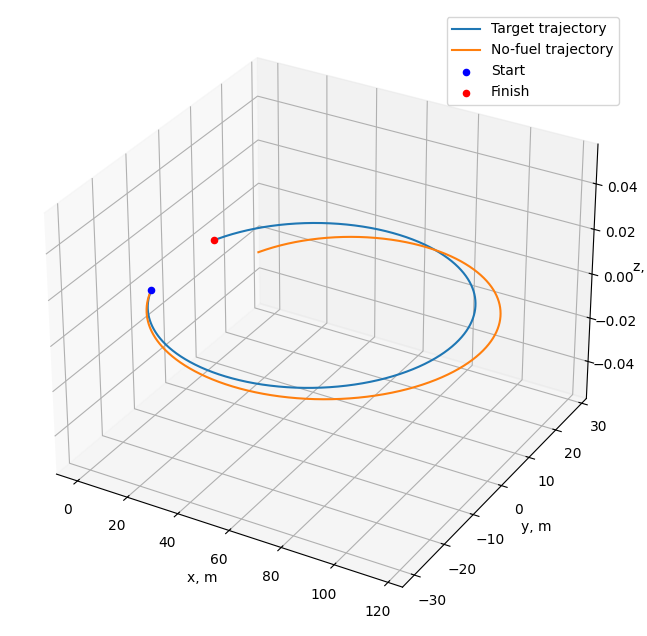

In [200]:
# Параметры
dt, T = 1., 5000
amax = 1e-4
w0 = o.v.W_ORB
t = np.linspace(0, T, int(T // dt))

# Целевая траектория
r0 = np.array([0, -10, 0])
r1 = np.array([0, 10, 0])
v0 = v0req(w0, T, r0, r1)
dr0 = np.zeros(3)  # np.array([0.1, 0.1, 0.1])
dv0 = -np.array([0.001, 0.001, 0.00])
kf.my_print(f"Положение: {r0} | Скорость: {v0}", bold=True)

#r1 = A(w0, T) @ r0 + B(w0, T) @ v0
v1 = C(w0, T) @ r0 + D(w0, T) @ v0

rt = np.zeros([int(T // dt), 3])
vt = np.zeros([int(T // dt), 3])
rn = np.zeros([int(T // dt), 3])
vn = np.zeros([int(T // dt), 3])
for i in range(int(T // dt)):
    rt[i] = A(w0, i*dt) @ r0 + B(w0, i*dt) @ v0
    vt[i] = C(w0, i*dt) @ r0 + D(w0, i*dt) @ v0
    rn[i] = A(w0, i*dt) @ (r0 + dr0) + B(w0, i*dt) @ (v0 + dv0)
    vn[i] = C(w0, i*dt) @ (r0 + dr0) + D(w0, i*dt) @ (v0 + dv0)

def my_show_3d(axes):
    axes.scatter(*[r0[i] for i in range(3)], c='b', label='Start')
    axes.scatter(*[r1[i] for i in range(3)], c='r', label='Finish')
    axes.legend()
    axes.set_xlabel("x, m")
    axes.set_ylabel("y, m")
    axes.set_zlabel("z, m")
    # axes.set_aspect('equal')
    plt.show()

axes = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
axes.plot(*[rt[:,i] for i in range(3)], label='Target trajectory')
axes.plot(*[rn[:,i] for i in range(3)], label='No-fuel trajectory')
my_show_3d(axes)

###### *ПД-регулятор относительно целевой траектории*

In [216]:
def PD_regulator(k_r=1e-4, k_v=1e-2, time_delay=500, amax=1e-4):
    r_control = rn.copy()
    v_control = vn.copy()
    u_list = np.zeros([int(T // dt), 3])
    
    for i in range(1, int(T // dt)):
        a1 = a_orb(w0, *r_control[i-1], *v_control[i-1])

        #-----------------------------------------------------------------------
        a2 = k_r * (rt[i-1] - r_control[i-1]) + k_v * (vt[i-1] - v_control[i-1])
        #-----------------------------------------------------------------------
        
        a2 = a2 if np.linalg.norm(a2) < amax else a2 * amax / np.linalg.norm(a2)
        if t[i] < time_delay:
            a2 = np.zeros(3)
        u_list[i] = a2
    
        v_control[i] = v_control[i-1] + (a1 + a2)*dt
        r_control[i] = r_control[i-1] + v_control[i]*dt
    dV = sum(np.linalg.norm(u_list[i, :]) for i in range(len(u_list)))
    
    axes = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
    axes.plot(*[rt[:,i] for i in range(3)], label='Target trajectory')
    axes.plot(*[rn[:,i] for i in range(3)], label='No-fuel trajectory')
    axes.plot(*[r_control[:,i] for i in range(3)], label='Controlled trajectory')
    my_show_3d(axes)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), gridspec_kw={'width_ratios': [2, 2, 2]})
    axs[2].plot(t, [np.linalg.norm(u_list[i, :]) for i in range(len(t))], 'k', label='|u|')
    for i in range(3):
        axs[0].plot(t, r_control[:, i] - rt[:,i], label=['Δx', 'Δy', 'Δz'][i])
        axs[1].plot(t, v_control[:, i] - vt[:,i], label=['Δvˣ', 'Δvʸ', 'Δvᶻ'][i])
        axs[2].plot(t, u_list[:, i], label=['uˣ', 'uʸ', 'uᶻ'][i])
    for i in range(3):
        axs[i].set_xlabel("time, s")
        axs[i].grid()
        axs[i].set_title(["coordinate error, m", "velocity error, m/s", "acceleration, m/s²"][i])
        axs[i].legend()
    kf.my_print(f"Затрачено dV = {dV} м/с", bold=True, color='b')
    kf.my_print(f"Максимальное ускорение: {amax} м/с²", bold=True)
    kf.my_print(f"Для 10 кг тяга двигателя: {(amax * 10)*1e3} мН\n")
    plt.show()

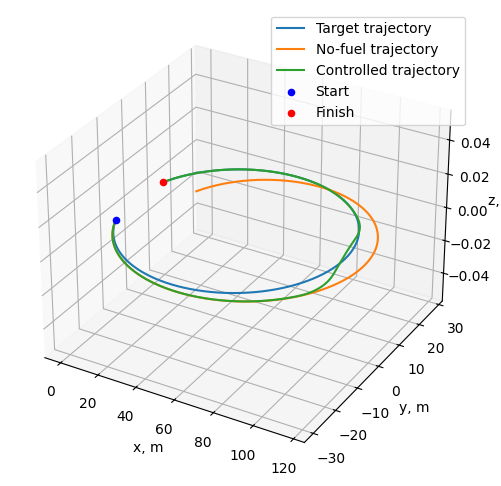

Затрачено dV = 0.09786412581528688 м/с
Максимальное ускорение: 0.0001 м/с²
Для 10 кг тяга двигателя: 1.0 мН



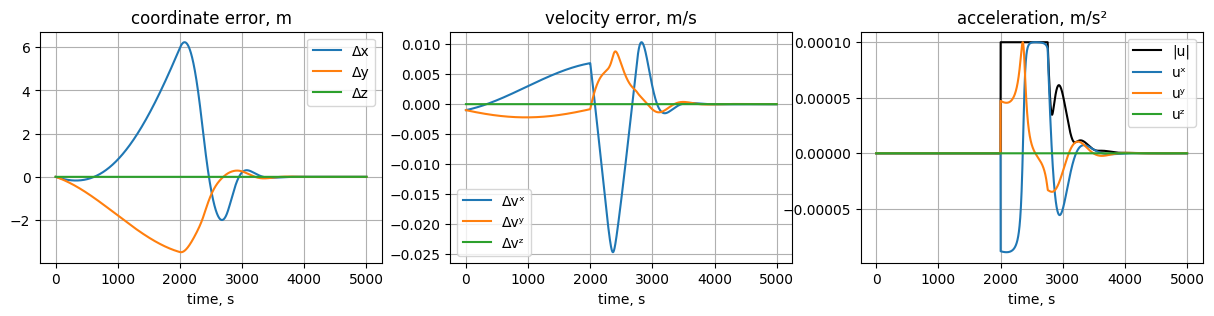

In [238]:
PD_regulator(k_r=1e-4, k_v=1e-2, time_delay=2000, amax=1e-4)

###### <u>П-регулятор относительно новой мгновенной траектории</u>

In [221]:
def P_regulator(k_v=1e-2, time_delay=500, amax=1e-4):
    r_control = rn.copy()
    v_control = vn.copy()
    u_list = np.zeros([int(T // dt), 3])
    CRUTCH = 2
    
    for i in range(1, int(T // dt)-2):
        a1 = a_orb(w0, *r_control[i-1], *v_control[i-1])
        v0_ = v0req(w0, T - t[i], r_control[i-1], r1)

        #-----------------------------------------------------------------------
        a2 = k_v * (v0_ - v_control[i-1])
        #-----------------------------------------------------------------------
        
        a2 = a2 if np.linalg.norm(a2) < amax else a2 * amax / np.linalg.norm(a2)
        if t[i] < time_delay:
            a2 = np.zeros(3)
        u_list[i] = a2
    
        v_control[i] = v_control[i-1] + (a1 + a2)*dt
        r_control[i] = r_control[i-1] + v_control[i]*dt
    dV = sum(np.linalg.norm(u_list[i, :]) for i in range(len(u_list)))
    
    axes = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
    axes.plot(*[rt[:,i] for i in range(3)], label='Target trajectory')
    axes.plot(*[rn[:,i] for i in range(3)], label='No-fuel trajectory')
    axes.plot(*[r_control[:-CRUTCH,i] for i in range(3)], label='Controlled trajectory')
    my_show_3d(axes)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 3), gridspec_kw={'width_ratios': [2, 2]})
    axs[1].plot(t, [np.linalg.norm(u_list[i, :]) for i in range(len(t))], 'k', label='|u|')
    for i in range(3):
        axs[0].plot(t[:-CRUTCH], r_control[:-CRUTCH, i] - rt[:-CRUTCH,i], label=['Δx', 'Δy', 'Δz'][i])
        # axs[1].plot(t[:-CRUTCH], v_control[:-CRUTCH, i] - vt[:-CRUTCH,i], label=['Δvˣ', 'Δvʸ', 'Δvᶻ'][i])
        axs[1].plot(t[:-CRUTCH], u_list[:-CRUTCH, i], label=['uˣ', 'uʸ', 'uᶻ'][i])
    for i in range(2):
        axs[i].set_xlabel("time, s")
        axs[i].grid()
        axs[i].set_title(["coordinate error, m", "acceleration, m/s²"][i]) # , "velocity error, m/s"
        axs[i].legend()
    kf.my_print(f"Затрачено dV = {dV} м/с", bold=True, color='b')
    kf.my_print(f"Максимальное ускорение: {amax} м/с²", bold=True)
    kf.my_print(f"Для 10 кг тяга двигателя: {(amax * 10)*1e3} мН\n")
    plt.show()

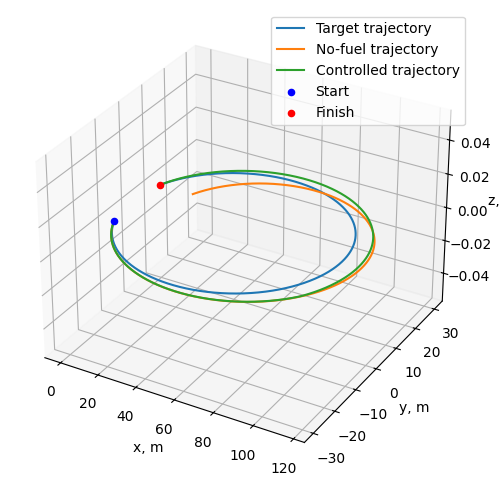

Затрачено dV = 0.004739611937428534 м/с
Максимальное ускорение: 0.0001 м/с²
Для 10 кг тяга двигателя: 1.0 мН



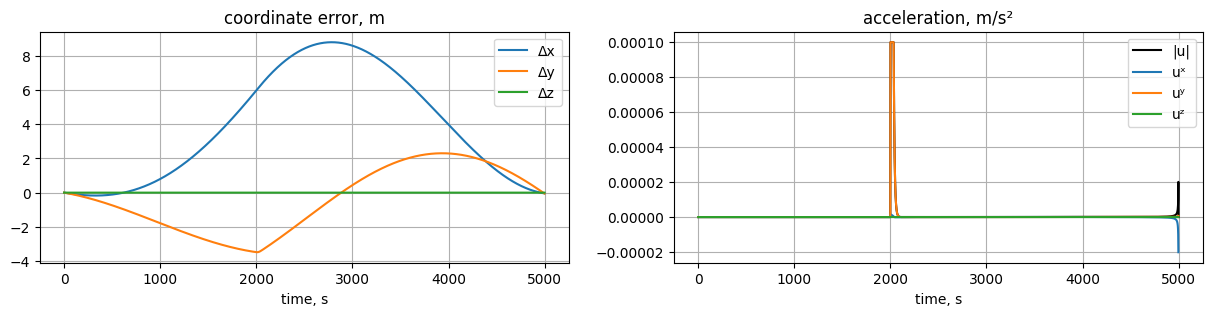

In [239]:
P_regulator(k_v=1e-1, time_delay=2000, amax=1e-4)

###### *Как в статье Izzo*   [**НУ НЕПРАВИЛЬНО ВСЁ**]

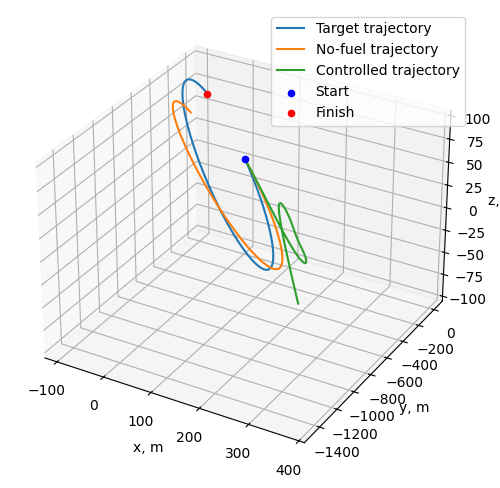

In [83]:
def v_gath(w: float, t: float, xi, r, T):
    tmp = np.zeros(3)
    B_1 = np.linalg.inv(B(w=w, t=t))
    B1 = np.linalg.inv(B(w=w, t=(T - t)))
    A_1 = A(w=w, t=t)
    A1 = A(w=w, t=(T - t))
    # print(f"1: {B_1 @ xi} | 2: {B_1 @ A1 @ r}")
    return B_1 @ xi - B_1 @ A1 @ r
    # return - B_1 @ A1 @ r

xi = r1

r_control = rn.copy()
v_control = v0 + dv0
u_list = np.zeros([int(T // dt), 3])

for i in range(1, int(T // dt)):
    a1 = a_orb(w0, *r_control[i-1], *v_control)
    
    v_target = v_gath(w=w0, t=t[i], xi=xi, T=T, r=r_control[i-1]) if i < int(T // dt) - 1 else np.zeros(3)  # Тут зарыт костыль
    a2 = (v_target - v_control) / dt
    a2 -= a1
    a2 = a2 if np.linalg.norm(a2) < amax else a2 * amax / np.linalg.norm(a2)
    u_list[i] = a2

    v_control += (a1 + a2)*dt
    # v_control = v_target  # Для отладки включить
    # v_control += (a1)*dt  # Для отладки включить
    r_control[i] = r_control[i-1] + v_control*dt

axes = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
axes.plot(rt[:,0], rt[:,1], rt[:,2], label='Target trajectory')
axes.plot(rn[:,0], rn[:,1], rn[:,2], label='No-fuel trajectory')
axes.plot(r_control[:,0], r_control[:,1], r_control[:,2], label='Controlled trajectory')
my_show_3d(axes)

Максимальное ускорение: 0.0001 м/с²
Для 5 кг тяга двигателя: 0.5 мН



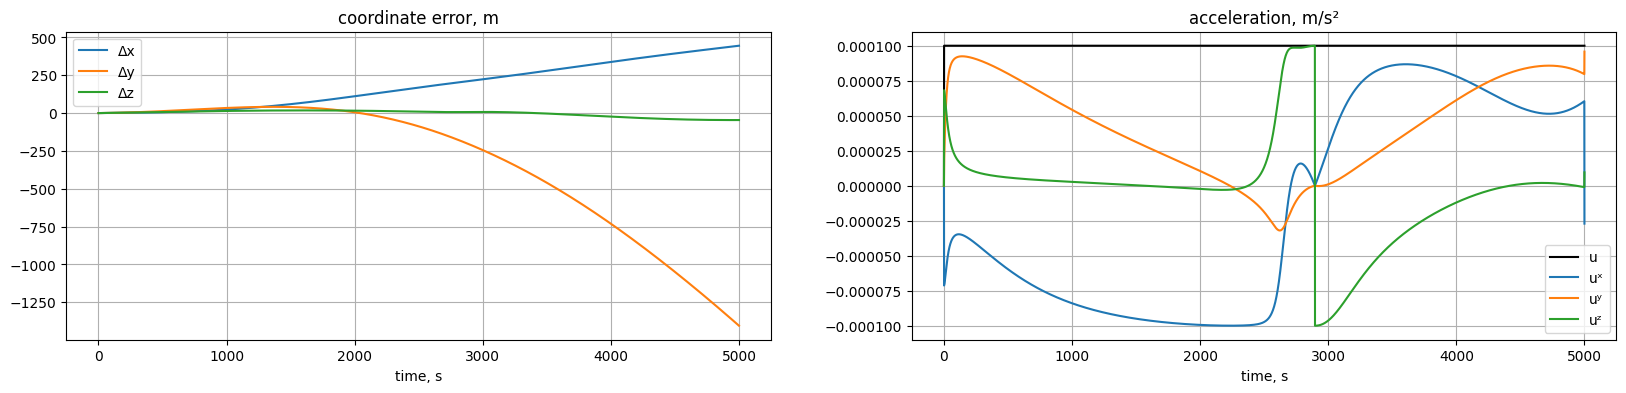

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[1].plot(t, [np.linalg.norm(u_list[i, :]) for i in range(len(t))], 'k', label='u')
for i in range(3):
    axs[0].plot(t, r_control[:, i] - rt[:,i], label=['Δx', 'Δy', 'Δz'][i])
    axs[1].plot(t, u_list[:, i], label=['uˣ', 'uʸ', 'uᶻ'][i])
for i in range(2):
    axs[i].set_xlabel("time, s")
    axs[i].grid()
    axs[i].set_title(["coordinate error, m", "acceleration, m/s²"][i])
    axs[i].legend()

kf.my_print(f"Максимальное ускорение: {amax} м/с²", bold=True)
kf.my_print(f"Для 5 кг тяга двигателя: {(amax * 5)*1e3} мН\n")
plt.show()

###### *Управление без обратной связи - исследование выпуклости*

In [17]:
from sympy.solvers.ode.systems import dsolve_system

In [20]:
t = var('t', real=True)
w, T, a1x, a1y, a1z, a2x, a2y, a2z = var('w T a_1^x a_1^y a_1^z a_2^x a_2^y a_2^z', constant=True, real=True)
x0, y0, z0, vx0, vy0, vz0 = var('x_0 y_0 z_0 v^x_0 v^y_0 v^z_0', real=True, constant=True)
x = Function('x')(t)
y = Function('y')(t)
z = Function('z')(t)
vx = Function('v_x')(t)
vy = Function('v_y')(t)
vz = Function('v_z')(t)
ax = a1x * t + a2x * (T - t)
ay = a1y * t + a2y * (T - t)
az = a1z * t + a2z * (T - t)
equations = {Eq(x.diff(t), vx),
             Eq(y.diff(t), vy),
             Eq(z.diff(t), vz),
             Eq(vx.diff(t), ax - 2 * w * vz),
             Eq(vy.diff(t), ay - w**2 * y),
             Eq(vz.diff(t), az + 3 * w**2 * z + 2 * w * vx)
            }

'equations = {Eq(x(t).diff(t), vx(t)),\n             Eq(y(t).diff(t), vy(t)),\n             Eq(z(t).diff(t), vz(t)),\n             Eq(vx(t).diff(t), ax - 2 * w * vz(t)),\n             Eq(vy(t).diff(t), ay - w**2 * y(t)),\n             Eq(vz(t).diff(t), az + 3 * w**2 * z(t) + 2 * w * vx(t))\n            }'

In [22]:
anw = dsolve(equations)  # , ics={x(0): x0, y(0): y0, z(0): z0, vx(0): vx0, vy(0): vy0, vz(0): vz0})

In [30]:
anw[0]

Eq(z(t), -2*C1/(3*w) + C2*sin(t*w)/(2*w) - C3*cos(t*w)/(2*w) + 2*T*a_2^x*t/w - 2*T*a_2^x*Piecewise((-cos(t*w)/w, Ne(w, 0)), (0, True))*sin(t*w)/w + 2*T*a_2^x*cos(t*w)*Integral(sin(t*w)**2/cos(t*w), t)/w - 2*T*a_2^x*cos(t*w)*Integral(1/cos(t*w), t)/w + T*a_2^z*Piecewise((sin(t*w)/w, Ne(w, 0)), (t, True))*sin(t*w)/w - T*a_2^z*cos(t*w)*Integral(sin(t*w), t)/w + t**2*(a_1^x - a_2^x)/w + 2*t*(a_1^x - a_2^x)*sin(t*w)*cos(t*w)/w**2 + t*(a_1^z - a_2^z)*sin(t*w)**2/w**2 - 2*(a_1^x - a_2^x)*cos(t*w)*Integral(t/cos(t*w), t)/w + 2*(a_1^x - a_2^x)*cos(t*w)*Integral(t*sin(t*w)**2/cos(t*w), t)/w - (a_1^z - a_2^z)*cos(t*w)*Integral(t*sin(t*w), t)/w - 2*(a_1^x - a_2^x)*sin(t*w)**2/w**3 + (a_1^z - a_2^z)*sin(t*w)*cos(t*w)/w**3)

**БЛЯДЬ**

In [31]:
t = var('t', real=True)
w, T, a1x, a1y, a1z, a2x, a2y, a2z = var('w T a_1^x a_1^y a_1^z a_2^x a_2^y a_2^z', constant=True, real=True)
x0, y0, z0, vx0, vy0, vz0 = var('x_0 y_0 z_0 v^x_0 v^y_0 v^z_0', real=True, constant=True)
x, y, z, vx, vy, vz = symbols("x y z v_x v_y v_z", cls=Function)
ax = a1x * t + a2x * (T - t)
ay = a1y * t + a2y * (T - t)
az = a1z * t + a2z * (T - t)
equations = {Eq(x(t).diff(t), vx(t)),
             Eq(y(t).diff(t), vy(t)),
             Eq(z(t).diff(t), vz(t)),
             Eq(vx(t).diff(t), ax - 2 * w * vz(t)),
             Eq(vy(t).diff(t), ay - w**2 * y(t)),
             Eq(vz(t).diff(t), az + 3 * w**2 * z(t) + 2 * w * vx(t))
            }

In [32]:
anw = dsolve_system(equations, ics={x(0): x0, y(0): y0, z(0): z0, vx(0): vx0, vy(0): vy0, vz(0): vz0})

In [34]:
anw[0][0]

Eq(z(t), 2*v^x_0/w + 4*z_0 + (v^z_0/w + (T*(2*a_2^x*Integral(sin(t*w), (t, 0)) - a_2^z*Integral(cos(t*w), (t, 0))) + 2*a_1^x*Integral(t*sin(t*w), (t, 0)) - a_1^z*Integral(t*cos(t*w), (t, 0)) - 2*a_2^x*Integral(t*sin(t*w), (t, 0)) + a_2^z*Integral(t*cos(t*w), (t, 0)))/w)*sin(t*w) - (2*v^x_0/w + 3*z_0 + (T*(2*a_2^x*(Integral(sin(t*w)**2/cos(t*w), (t, 0)) - Integral(1/cos(t*w), (t, 0))) - a_2^z*Integral(sin(t*w), (t, 0))) - 2*a_1^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) - a_1^z*Integral(t*sin(t*w), (t, 0)) + 2*a_2^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + a_2^z*Integral(t*sin(t*w), (t, 0)))/w)*cos(t*w) - 2*(T*a_2^x*Integral(1, (t, 0)) + a_1^x*Integral(t, (t, 0)) - a_2^x*Integral(t, (t, 0)))/w + sin(t*w)*Integral(-2*T*a_2^x*sin(t*w) + T*a_2^z*cos(t*w) - 2*a_1^x*t*sin(t*w) + a_1^z*t*cos(t*w) + 2*a_2^x*t*sin(t*w) - a_2^z*t*cos(t*w), t)/w - cos(t*w)*Integral(-2*T*a_2^x*sin(t*w)**2/cos(t*w) + 2*T*a_2^x/cos(t*w) + T*a_2^z*si

**МАМА**

In [36]:
tmp_0 = anw[0][0].simplify()
tmp_0

Eq(z(t), (2*T*a_2^x*t - t**2*(-a_1^x + a_2^x) + 2*v^x_0 + 4*w*z_0 + (2*T*a_2^x*Piecewise((-1/w, Ne(w, 0)), (0, True)) - a_1^z/w**2 + a_2^z/w**2 + v^z_0)*sin(t*w) - (-T*a_2^z*Piecewise((-1/w, Ne(w, 0)), (0, True)) - 2*a_1^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + 2*a_2^x*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + 2*v^x_0 + 3*w*z_0)*cos(t*w) + (-2*T*a_2^x*Piecewise((-cos(t*w)/w, Ne(w, 0)), (0, True)) + T*a_2^z*Piecewise((sin(t*w)/w, Ne(w, 0)), (t, True)) - 2*a_1^x*(-t*cos(t*w)/w + sin(t*w)/w**2) + a_1^z*(t*sin(t*w)/w + cos(t*w)/w**2) + 2*a_2^x*(-t*cos(t*w)/w + sin(t*w)/w**2) - a_2^z*(t*sin(t*w)/w + cos(t*w)/w**2))*sin(t*w) - (-Integral(-4*T*a_2^x/cos(t*w), t) - Integral(-4*a_1^x*t/cos(t*w), t) - Integral(4*a_2^x*t/cos(t*w), t) - Integral(4*T*a_2^x*sin(t*w)**2/cos(t*w), t) - Integral(-T*a_2^z*sin(2*t*w)/cos(t*w), t) - Integral(4*a_1^x*t*sin(t*w)**2/cos(t*w), t) - Integral(-a_1^z*t*sin(2*t*w)/cos(t*w), t) - Integral(-4*a_

**ХОРОШО уговорил давай полиномом**

In [37]:
t = var('t', real=True)
w, T, a1x, a1y, a1z, a2x, a2y, a2z = var('w T a_1^x a_1^y a_1^z a_2^x a_2^y a_2^z', constant=True, real=True)
x0, y0, z0, vx0, vy0, vz0 = var('x_0 y_0 z_0 v^x_0 v^y_0 v^z_0', real=True, constant=True)
x, y, z, vx, vy, vz = symbols("x y z v_x v_y v_z", cls=Function)
ax = a1x + a2x * t
ay = a1y + a2y * t
az = a1z + a2z * t
equations = {Eq(x(t).diff(t), vx(t)),
             Eq(y(t).diff(t), vy(t)),
             Eq(z(t).diff(t), vz(t)),
             Eq(vx(t).diff(t), ax - 2 * w * vz(t)),
             Eq(vy(t).diff(t), ay - w**2 * y(t)),
             Eq(vz(t).diff(t), az + 3 * w**2 * z(t) + 2 * w * vx(t))
            }

In [38]:
anw = dsolve_system(equations, ics={x(0): x0, y(0): y0, z(0): z0, vx(0): vx0, vy(0): vy0, vz(0): vz0})

In [39]:
anw[0][0]

Eq(v_z(t), (2*a_1^x*Integral(sin(t*w), (t, 0)) + a_1^z*(Integral(sin(t*w)**2/cos(t*w), (t, 0)) - Integral(1/cos(t*w), (t, 0))) + 2*a_2^x*Integral(t*sin(t*w), (t, 0)) - a_2^z*(Integral(t/cos(t*w), (t, 0)) - Integral(t*sin(t*w)**2/cos(t*w), (t, 0))) + v^z_0)*cos(t*w) - (2*a_1^x*Integral(cos(t*w), (t, 0)) + a_1^z*Integral(sin(t*w), (t, 0)) + 2*a_2^x*Integral(t*cos(t*w), (t, 0)) + a_2^z*Integral(t*sin(t*w), (t, 0)) - 2*v^x_0 - 3*w*z_0)*sin(t*w) + sin(t*w)*Integral(2*a_1^x*cos(t*w) + a_1^z*sin(t*w) + 2*a_2^x*t*cos(t*w) + a_2^z*t*sin(t*w), t) + cos(t*w)*Integral(-2*a_1^x*sin(t*w) - a_1^z*sin(t*w)**2/cos(t*w) + a_1^z/cos(t*w) - 2*a_2^x*t*sin(t*w) - a_2^z*t*sin(t*w)**2/cos(t*w) + a_2^z*t/cos(t*w), t))

##### <u>Непрерывное управление с учётом столкновения</u>

###### *Доказательство отсутствия "ложных точек равновесия" при исскуственно созданном потенциале*

In [ ]:
# Допустим, есть цилиндрическое препятствие
rh = 

##### <u>Импульсное управление с учётом столкновения</u>

###### *Сценарий 1*

1. Аппарат выбирает траекторию, близку к требуемой (ошибки отталкивания или невозможность из-за огибания)
2. Когда есть прямая видимость с точкой, аппарат даёт корректирующий импульс

In [8]:
def data_for_cylinder_along_x(center_y, center_z, radius, x0, x1, alongation):
    x = np.linspace(x0, x1, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, x_grid=np.meshgrid(theta, x)
    y_grid = radius*np.cos(theta_grid) + center_y
    z_grid = radius*np.sin(theta_grid) + center_z
    if alongation == 'x':
        return x_grid, y_grid, z_grid
    if alongation == 'y':
        return y_grid, x_grid, z_grid 

In [140]:
def show_impulse_correction(T=5000, dt=50, is_show: bool = True):
    alongation = 'y'
    a = 'xyz'.index(alongation)
    ro1, ro2 = np.array([0, -1, 0]), np.array([0, 1, 0])
    r0, r1 = ro1, ro2  # Специфика сценария
    d = 0.5
    w0 = o.v.W_ORB
    dv = -np.array([0.0001, 0.0001, 0.0001])
    v0 = v0req(w0, T, r0, r1) + dv  # С ОШИБКОЙ ИМПУЛЬСА
    print(f"v₀ = {v0req(w0, T, r0, r1)} + {dv}")

    if is_show:
        axes = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
        Xc,Yc,Zc = data_for_cylinder_along_x(r0[(a+1)%3], r0[(a+2)%3], d, r0[a], r1[a], alongation=alongation)
        axes.plot_surface(Xc, Yc, Zc, alpha=0.5, label='Chief spacecraft')
        axes.scatter(*r0, c='b', label='Start')
        axes.scatter(*r1, c='r', label='Finish')
    
    flag_vision = False
    last_flag = True
    r_1 = []
    r_2 = []
    t = 0
    for i in range(int(T // dt)):
        t += dt
        r_1.append(A(w0, t) @ r0 + B(w0, t) @ v0)
    t = 0
    for i in range(int(T // dt)-1):
        t += dt
        r = A(w0, t) @ r0 + B(w0, t) @ v0
        # Проверка видимости (каждый шаг по времени)
        hi = h(r1=r, r2=r1+0.01*np.array([int(alongation=='x'),int(alongation=='y'),int(alongation=='z')]), ro1=ro1, ro2=ro2)
        flag_vision = hi > 0
        if is_show:
            axes.plot(*[[r[j], r1[j]] for j in range(3)], c='g' if flag_vision else 'gray', alpha=0.5, lw=1,
                      label='Vision-off lines' if (last_flag and not flag_vision) else 
                            'Vision-on lines' if (not last_flag and flag_vision) else None)
        # Корректируюзий импульс
        if flag_vision and not last_flag:
            r0 = r.copy()
            v0 = v0req(w0, T - t, r0, r1)
            time_notice = t
            t = 0
            if is_show:
                axes.scatter(*r0, c='k', label='Point of correction')
        if flag_vision:
            r_2.append(r)
            
        last_flag = flag_vision

    r_1 = np.array(r_1)
    r_2 = np.array(r_2)
    dv_correct = []
    for Δt in delay:
        t = time_notice + Δt
        r = A(w0, t) @ r0 + B(w0, t) @ v0
        v = C(w0, t) @ r0 + D(w0, t) @ v0
        v0_new = v0req(w0, T - t, r, r1)
        dv_correct.append(norm(v0_new - v))
    if is_show:
        kf.my_print(f"Время обнаружения цели: {time_notice} сек | осталось {T - time_notice} сек", bold=True)
        axes.plot(*[r_1[:,i] for i in range(3)], c='r', label='Error trajectory')
        axes.plot(*[r_2[:,i] for i in range(3)], c='b', label='Corrected trajectory')
        axes.legend()
        axes.set_xlabel("x, m")
        axes.set_ylabel("y, m")
        axes.set_zlabel("z, m")
        axes.set_aspect("equal")
        plt.show()
        
        plt.plot(delay, dv_correct)
        plt.xlabel("Delay of correction Δt, s")
        plt.ylabel("Correction velocity |dV|, m/s")
        plt.grid()
        plt.show()
    return np.array(dv_correct)

v₀ = [ 0.00221695 -0.00285446  0.        ] + [-0.0001 -0.0001 -0.0001]
Время обнаружения цели: 2900 сек | осталось 2100 сек


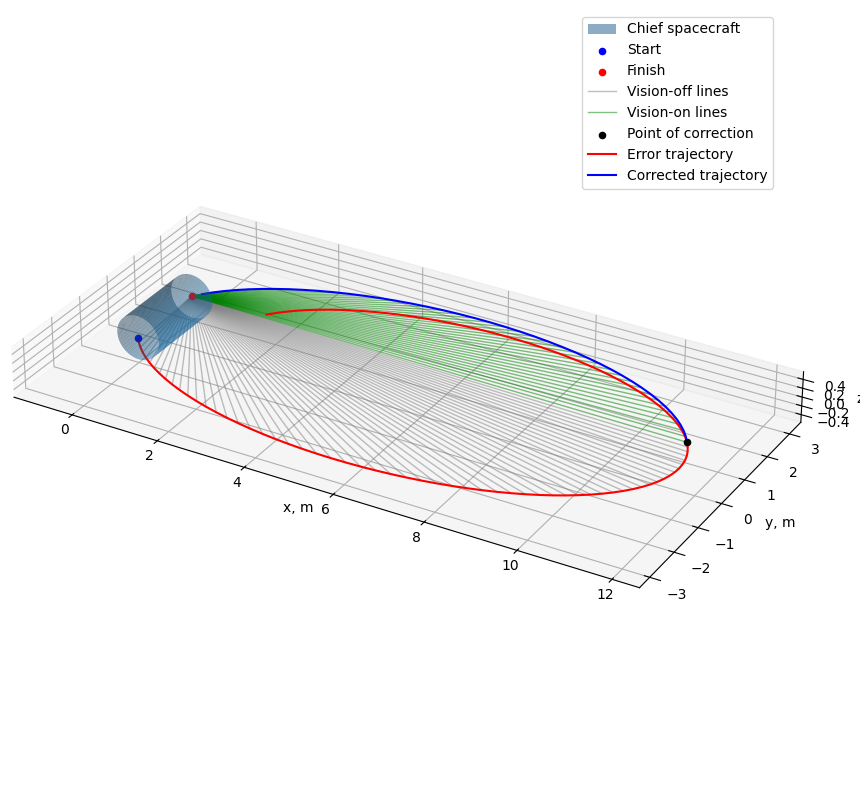

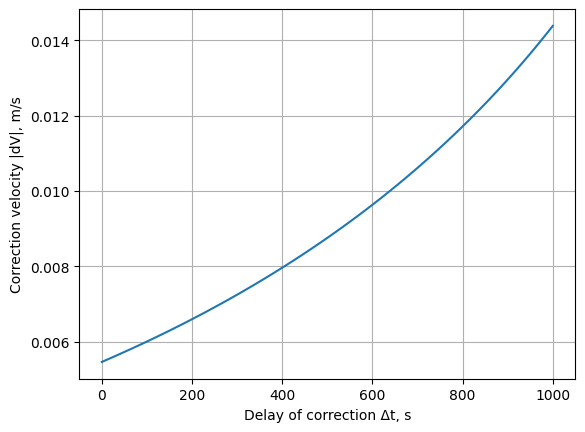

In [141]:
delay = np.linspace(0, 1000, 100)
_ = show_impulse_correction(T=5000)

In [142]:
data = pd.DataFrame()
for T in [4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500]:
    data[f'{T}'] = show_impulse_correction(T=T, is_show=False)

v₀ = [ 0.00221695 -0.00164804  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.00186322  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.00212268  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.00244381  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.00285446  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.003402    0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.00417427  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.00535446  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.00739882  0.        ] + [-0.0001 -0.0001 -0.0001]
v₀ = [ 0.00221695 -0.0118478   0.        ] + [-0.0001 -0.0001 -0.0001]


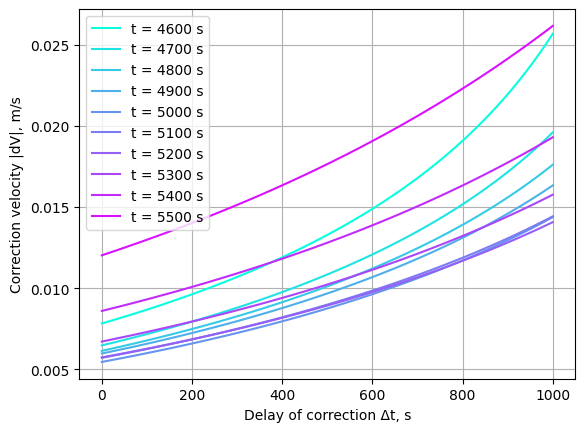

In [224]:
for i, c in enumerate(data.columns):
    plt.plot(delay, data[c], label=f"t = {c} s", color=mycolor(np.linspace(0, 1, len(data.columns))[i]))
plt.xlabel("Delay of correction Δt, s")
plt.ylabel("Correction velocity |dV|, m/s")
plt.legend()
plt.grid()
plt.show()